# MRI Foundation Models: Pre-Trained Models' Evaluation

## SPM/CAT12 Preprocessing | AnatCL | HBN 

In [ ]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/HBN_BIDS/new_cat12_preprocessing.py

import os
import glob
import boutiques
from boutiques import bosh
from boutiques.descriptor2func import function

boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/HBN_BIDS"
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"

bosh(["exec", 
      "prepare", 
      boutiques_descriptor, 
      "--imagepath", 
      "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"
])

cat12 = boutiques.descriptor2func.function(boutiques_descriptor)

t1_nii_files = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "sub-*_T1w.nii"))
print(f"Found {len(t1_nii_files)} T1w files.")

task_id = int(os.environ["SLURM_ARRAY_TASK_ID"])

if task_id >= len(t1_nii_files) or task_id < 0:
    print(f"SLURM_ARRAY_TASK_ID={task_id} out of range")
    exit(1)

input_file = t1_nii_files[task_id]

path_parts = input_file.split(os.sep)
subject_id = next((part for part in path_parts if part.startswith("sub-")), None)

if subject_id is None:
        print(f"No subject ID in path: {input_file}")
        exit(1)

filename = os.path.basename(input_file)

subject_output_dir = os.path.join(output_dir, subject_id)
os.makedirs(subject_output_dir, exist_ok=True)

print(f"Processing={task_id} -> file: {filename} (subject: {subject_id})")

result = cat12('--imagepath=/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif', 
                   input_file=input_file, 
                   output_dir=subject_output_dir)

result_dict = vars(result)
print("Available result keys:", result_dict.keys())
print("\nExit code:", result_dict.get("exit_code"))
print("\nStdout:\n", result_dict.get ("stdout" ))
print("\nStderr:\n", result_dict.get ("stderr"))
print("\nOutput files:\n", result_dict.get("output_files"))

In [ ]:
%%sbatch --array=500-520
#!/bin/bash
#SBATCH --job-name=CAT12_preproc
#SBATCH --account=rrg-glatard
#SBATCH --mem=12G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=CAT12_preproc_%A_%a.out
#SBATCH --error=CAT12_preproc_%A_%a.err
#SBATCH --time=1:0:0

source ~/.venvs/jupyter_py3/bin/activate

module load apptainer

cd ~/links/projects/rrg-glatard/arelbaha/HBN_BIDS #Location of preprocessing data and script

echo "Running task ID: $SLURM_ARRAY_TASK_ID"

python new_cat12_preprocessing.py

## SPM/CAT12 Preprocessing | AnatCL | PPMI

In [ ]:
%%writefile ~/links/projects/def-glatard/arelbaha/data/inputs/ppmicat12_preprocessing.py

import os
import glob
import boutiques
from boutiques import bosh
from boutiques.descriptor2func import function

#Downloading Container Part + Paths
boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"
base_dir = "/home/arelbaha/links/projects/def-glatard/arelbaha/data/inputs"
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"

bosh(["exec", "prepare", boutiques_descriptor, "--imagepath", "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"])
cat12 = boutiques.descriptor2func.function(boutiques_descriptor)

#Task ID Extraction
data = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "*.nii"))
print(f"Found {len(data)}")

task_id = int(os.environ["SLURM_ARRAY_TASK_ID"])

if task_id >= len(data) or task_id < 0:
    print(f"SLURM_ARRAY_TASK_ID={task_id} out of range")
    exit(1)

input_file = data[task_id]

path_parts = input_file.split(os.sep)
subject_id = next((part for part in path_parts if part.startswith("sub-")), None)

if subject_id is None:
        print(f"Could not find subject ID in path: {input_file}")
        exit(1)

filename = os.path.basename(input_file)

subject_output_dir = os.path.join(output_dir, subject_id)
os.makedirs(subject_output_dir, exist_ok=True)

print(f"Processing SLURM_ARRAY_TASK_ID ={task_id} -> file: {filename} (subject: {subject_id})")

result = cat12('--imagepath=/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif', 
                   input_file=input_file, 
                   output_dir=subject_output_dir)

result_dict = vars(result)
print("Available result keys:", result_dict.keys())
print("\nExit code:", result_dict.get("exit_code"))
print("\nStdout:\n", result_dict.get ("stdout" ))
print("\nStderr:\n", result_dict.get ("stderr"))
print("\nOutput files:\n", result_dict.get("output_files"))

In [ ]:
%%sbatch --array=1040-1040
#!/bin/bash
#SBATCH --job-name=CAT12_parkinson_preproc
#SBATCH --account=rrg-glatard
#SBATCH --mem=12G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=parkinson_preproc_%A_%a.out
#SBATCH --error=parkinson_preproc_%A_%a.err
#SBATCH --time=1:0:0

source ~/.venvs/jupyter_py3/bin/activate

module load apptainer

cd ~/links/projects/def-glatard/arelbaha/data/inputs #Location of preprocessing data and script

echo "Running task ID: $SLURM_ARRAY_TASK_ID"

python classification_parkinson.py

### HD-BET Preprocessing | BrainIAC, CNN, SwinBrain | PPMI

In [ ]:
%%sbatch --array=23,24
#!/bin/bash
#SBATCH --account=def-glatard
#SBATCH --time=20:00:00
#SBATCH --mem=16G
#SBATCH --cpus-per-task=4
#SBATCH --job-name=brainiac_batch
#SBATCH --output=logs/prep_batch_%a.out
#SBATCH --error=logs/prep_batch_%a.err

export BASE_DIR="/home/arelbaha/links/projects/def-glatard/arelbaha/data"
export RAW_DIR="${BASE_DIR}/raw_files_brainiac"
export OUTPUT_DIR="${BASE_DIR}/processed_outputs"

# Load environment
module load python/3.11
module load opencv
source /home/arelbaha/.venvs/brainiac_env/bin/activate

BATCH_DIR="${RAW_DIR}/batch_${SLURM_ARRAY_TASK_ID}"
BATCH_OUTPUT="${OUTPUT_DIR}/batch_${SLURM_ARRAY_TASK_ID}"

mkdir -p "$BATCH_OUTPUT"

echo "Processing batch ${SLURM_ARRAY_TASK_ID} from ${BATCH_DIR}"

python /home/arelbaha/.venvs/brainiac_env/lib/python3.11/site-packages/BrainIAC/src/preprocessing/mri_preprocess_3d_simple.py \
    --temp_img /home/arelbaha/.venvs/brainiac_env/lib/python3.11/site-packages/BrainIAC/src/preprocessing/atlases/temp_head.nii.gz \
    --input_dir "$BATCH_DIR" \
    --output_dir "$BATCH_OUTPUT"

echo "Completed batch ${SLURM_ARRAY_TASK_ID}"

## HD-BET Preprocessing | BrainIAC, CNN, SwinBrain | HBN

In [ ]:
%%sbatch --array=1-100
#!/bin/bash
#SBATCH --account=def-glatard
#SBATCH --time=12:00:00
#SBATCH --mem=16G
#SBATCH --cpus-per-task=4
#SBATCH --job-name=brainiac_batch
#SBATCH --output=logs/prep_batch_%a.out
#SBATCH --error=logs/prep_batch_%a.err

export BASE_DIR="/home/arelbaha/links/projects/rrg-glatard/arelbaha"
export RAW_DIR="${BASE_DIR}/brainiac_p_files"
export OUTPUT_DIR="${BASE_DIR}/brainiac_p_outputs"

module load python/3.11
module load opencv
source /home/arelbaha/.venvs/brainiac_env/bin/activate

#Batch
BATCH_NUM=$(printf "%03d" ${SLURM_ARRAY_TASK_ID})
BATCH_DIR="${RAW_DIR}/batch_${BATCH_NUM}"
BATCH_OUTPUT="${OUTPUT_DIR}/batch_${BATCH_NUM}"

mkdir -p "$BATCH_OUTPUT"
echo "Processing batch ${BATCH_NUM} from ${BATCH_DIR}"

#Preprocessing
python /home/arelbaha/.venvs/brainiac_env/lib/python3.11/site-packages/BrainIAC/src/preprocessing/mri_preprocess_3d_simple.py \
    --temp_img /home/arelbaha/.venvs/brainiac_env/lib/python3.11/site-packages/BrainIAC/src/preprocessing/atlases/temp_head.nii.gz \
    --input_dir "$BATCH_DIR" \
    --output_dir "$BATCH_OUTPUT"

echo "Completed batch ${BATCH_NUM}"

## Multi-Task Evaluation of Models | HBN and PPMI

In [2]:
%%writefile /home/arelbaha/links/projects/rrg-glatard/arelbaha/new_combined_multimodel_comparison_w_permutation.py

import os
import glob
import random
import numpy as np
import pandas as pd

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import nibabel as nib
from anatcl import AnatCL
from monai.networks.nets import ViT, SwinUNETR
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier, DummyRegressor
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import permutation_test
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from matplotlib.patches import Patch

SEEDS = [0, 1, 2, 3, 42]

random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

device = "cpu"
DROPOUT_RATE = 0.3
ANATCL_ENCODER_PATH = "/home/arelbaha/.venvs/jupyter_py3/bin"
BRAINIAC_CKPT = "/home/arelbaha/.venvs/jupyter_py3/bin/BrainIAC.ckpt"
SWINBRAIN_CKPT = "/home/arelbaha/.venvs/jupyter_py3/bin/Brain_Swin_UNETR.pth"

class CAT12VBMDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.data, self.labels, self.transform = data, labels, transform
        self.target_shape = (121, 128, 121)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = nib.load(self.data[idx]).get_fdata().astype(np.float32)
        if img.shape != self.target_shape:
            img = F.interpolate(torch.from_numpy(img[None, None]), size=self.target_shape,
                               mode='trilinear', align_corners=False).squeeze().numpy()
        img = self.transform(img).unsqueeze(0)
        return img, torch.tensor(self.labels[idx], dtype=torch.float32)
        
class BrainIACDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = nib.load(self.paths[idx]).get_fdata().astype(np.float32)
        if img.shape != (96, 96, 96):
            img = F.interpolate(torch.from_numpy(img[None, None]), size=(96, 96, 96), 
                              mode='trilinear', align_corners=False).squeeze().numpy()
        img_tensor = torch.from_numpy(img)
        img_normalized = self.transform(img_tensor)
        return img_normalized[None], torch.tensor(self.labels[idx], dtype=torch.float32)

class SwinBrainDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths, self.labels = paths, labels
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = nib.load(self.paths[idx]).get_fdata().astype(np.float32)
        img = F.interpolate(torch.from_numpy(img[None, None]), size=(128, 128, 64),
                           mode='trilinear', align_corners=False).squeeze(0)
        img = (img - img.mean()) / (img.std() + 1e-6)
        img = img.repeat(3, 1, 1, 1)
        return img, torch.tensor(self.labels[idx], dtype=torch.float32)

class CNNDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = nib.load(self.paths[idx]).get_fdata().astype(np.float32)
        if img.shape != (92, 110, 92):
            img = ndi.zoom(img, [92/img.shape[0], 110/img.shape[1], 92/img.shape[2]], order=1)
        img = (img - img.mean()) / (img.std() + 1e-6)
        return torch.from_numpy(img[None]).float()

class CNN3D(nn.Module):
    def __init__(self, dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, 3, padding=1)
        self.bn1, self.pool1, self.drop1 = nn.BatchNorm3d(64), nn.MaxPool3d(2), nn.Dropout3d(dropout_rate)
        self.conv2 = nn.Conv3d(64, 64, 3, padding=1)
        self.bn2, self.pool2, self.drop2 = nn.BatchNorm3d(64), nn.MaxPool3d(2), nn.Dropout3d(dropout_rate)
        self.conv3 = nn.Conv3d(64, 128, 3, padding=1)
        self.bn3, self.pool3, self.drop3 = nn.BatchNorm3d(128), nn.MaxPool3d(2), nn.Dropout3d(dropout_rate)
        self.conv4 = nn.Conv3d(128, 256, 3, padding=1)
        self.bn4, self.pool4, self.drop4 = nn.BatchNorm3d(256), nn.MaxPool3d(2), nn.Dropout3d(dropout_rate)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1, self.drop5 = nn.Linear(256, 512), nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.drop1(self.bn1(self.pool1(F.relu(self.conv1(x)))))
        x = self.drop2(self.bn2(self.pool2(F.relu(self.conv2(x)))))
        x = self.drop3(self.bn3(self.pool3(F.relu(self.conv3(x)))))
        x = self.drop4(self.bn4(self.pool4(F.relu(self.conv4(x)))))
        return self.drop5(F.relu(self.fc1(self.global_pool(x).view(x.size(0), -1))))

def load_brainiac_vit(ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    vit = ViT(in_channels=1, img_size=(96, 96, 96), patch_size=(16, 16, 16),
              hidden_size=768, mlp_dim=3072, num_layers=12, num_heads=12, save_attn=True)
    pe_key = "backbone.patch_embedding.position_embeddings"
    if pe_key in ckpt.get("state_dict", ckpt):
        vit.patch_embedding.position_embeddings = nn.Parameter(ckpt["state_dict"][pe_key].clone())
    backbone_state = {k.replace("backbone.", ""): v for k, v in ckpt.get("state_dict", ckpt).items() 
                     if k.startswith("backbone.")}
    vit.load_state_dict(backbone_state, strict=False)
    return vit.to(device).eval()

def load_swinbrain(ckpt_path, device):
    model = SwinUNETR(img_size=(128, 128, 64), in_channels=3, out_channels=3, spatial_dims=3,
                      feature_size=24, drop_rate=0.0, attn_drop_rate=0.0)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    clean_state = {k.replace("module.", ""): v for k, v in ckpt.items()}
    model.load_state_dict(clean_state, strict=True)
    return model.to(device).eval()

def run_classification(X_dict, y, test_size=0.1, task_name="Classification"):
    print(f"\n{task_name}")
    results = {}
    alphas = [0.01, 0.05, 0.1, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]

    dummy_cv_acc, dummy_cv_auc, dummy_test_acc, dummy_test_auc = [], [], [], []
    for seed in SEEDS:
        cv_idx, test_idx = train_test_split(np.arange(len(y)), test_size=int(test_size * len(y)), 
                                            stratify=y, random_state=seed)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        for train_rel, val_rel in skf.split(cv_idx, y[cv_idx]):
            train_idx, val_idx = cv_idx[train_rel], cv_idx[val_rel]
            dummy = DummyClassifier(strategy='stratified', random_state=seed)
            dummy.fit(np.zeros((len(train_idx), 1)), y[train_idx])
            dummy_cv_acc.append(balanced_accuracy_score(y[val_idx], dummy.predict(np.zeros((len(val_idx), 1)))))
            dummy_cv_auc.append(roc_auc_score(y[val_idx], dummy.predict_proba(np.zeros((len(val_idx), 1)))[:, 1]))
        
        dummy = DummyClassifier(strategy='stratified', random_state=seed)
        dummy.fit(np.zeros((len(cv_idx), 1)), y[cv_idx])
        dummy_test_acc.append(balanced_accuracy_score(y[test_idx], dummy.predict(np.zeros((len(test_idx), 1)))))
        dummy_test_auc.append(roc_auc_score(y[test_idx], dummy.predict_proba(np.zeros((len(test_idx), 1)))[:, 1]))
    
    results['DummyClassifier'] = {
        'best_alpha': 1.0,
        'test_acc_mean': np.mean(dummy_test_acc), 'test_acc_std': np.std(dummy_test_acc),
        'test_auc_mean': np.mean(dummy_test_auc), 'test_auc_std': np.std(dummy_test_auc),
        'cv_auc_mean': np.mean(dummy_cv_auc), 'cv_auc_std': np.std(dummy_cv_auc),
        'cv_acc_mean': np.mean(dummy_cv_acc), 'cv_acc_std': np.std(dummy_cv_acc),
        'fold_results': {'val_auc': dummy_cv_auc, 'val_acc': dummy_cv_acc}
    }
    print(f"Dummy: AUC={np.mean(dummy_test_auc):.3f}±{np.std(dummy_test_auc):.3f}")

    for model, X in X_dict.items():
        all_val_auc = {a: [] for a in alphas}
        all_val_acc = {a: [] for a in alphas}
        all_train_auc = {a: [] for a in alphas}
        all_train_acc = {a: [] for a in alphas}
        all_test_acc, all_test_auc = [], []
        
        for seed in SEEDS:
            cv_idx, test_idx = train_test_split(np.arange(len(y)), test_size=int(test_size * len(y)), 
                                                stratify=y, random_state=seed)
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
            
            for train_rel, val_rel in skf.split(cv_idx, y[cv_idx]):
                train_idx, val_idx = cv_idx[train_rel], cv_idx[val_rel]
                for alpha in alphas:
                    n = int(alpha * len(train_idx))
                    if n >= len(train_idx):
                        tr_idx = train_idx
                    else:
                        tr_idx, _ = train_test_split(train_idx, train_size=n, stratify=y[train_idx], random_state=seed)
                    if len(np.unique(y[tr_idx])) < 2:
                        continue

                    scaler = StandardScaler()
                    rf = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_split=5,
                                               random_state=seed, n_jobs=1, max_features='sqrt', class_weight='balanced')
                    rf.fit(scaler.fit_transform(X[tr_idx]), y[tr_idx])
                    val_pred_proba = rf.predict_proba(scaler.transform(X[val_idx]))[:, 1]
                    all_val_acc[alpha].append(balanced_accuracy_score(y[val_idx], rf.predict(scaler.transform(X[val_idx]))))
                    all_val_auc[alpha].append(roc_auc_score(y[val_idx], val_pred_proba))
                    all_train_acc[alpha].append(balanced_accuracy_score(y[tr_idx], rf.predict(scaler.transform(X[tr_idx]))))
                    all_train_auc[alpha].append(roc_auc_score(y[tr_idx], rf.predict_proba(scaler.transform(X[tr_idx]))[:, 1]))

            scaler = StandardScaler()
            rf = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_split=5,
                                        random_state=seed, n_jobs=1, max_features='sqrt', class_weight='balanced')
            rf.fit(scaler.fit_transform(X[cv_idx]), y[cv_idx])
            test_pred_proba = rf.predict_proba(scaler.transform(X[test_idx]))[:, 1]
            all_test_acc.append(balanced_accuracy_score(y[test_idx], rf.predict(scaler.transform(X[test_idx]))))
            all_test_auc.append(roc_auc_score(y[test_idx], test_pred_proba))

        avg_auc = {a: np.mean(all_val_auc[a]) for a in alphas if all_val_auc[a]}
        best_alpha = max(avg_auc, key=avg_auc.get)
        train_val_gaps = {a: np.mean(all_train_auc[a]) - np.mean(all_val_auc[a]) for a in alphas if all_train_auc[a] and all_val_auc[a]}
        
        results[model] = {
            'best_alpha': best_alpha,
            'test_acc_mean': np.mean(all_test_acc), 'test_acc_std': np.std(all_test_acc),
            'test_auc_mean': np.mean(all_test_auc), 'test_auc_std': np.std(all_test_auc),
            'cv_auc_mean': np.mean(all_val_auc[best_alpha]), 'cv_auc_std': np.std(all_val_auc[best_alpha]),
            'cv_acc_mean': np.mean(all_val_acc[best_alpha]), 'cv_acc_std': np.std(all_val_acc[best_alpha]),
            'train_val_gap': train_val_gaps.get(best_alpha, 0),
            'is_overfitting': train_val_gaps.get(best_alpha, 0) > 0.25,
            'fold_results': {'val_auc': all_val_auc[best_alpha], 'val_acc': all_val_acc[best_alpha]},
            'fold_results_alpha1': {'val_acc': all_val_acc[1.0], 'val_auc': all_val_auc[1.0]},
            'cv_results': {
                'alphas': alphas, 
                'acc': {a: np.mean(all_val_acc[a]) for a in alphas if all_val_acc[a]},
                'auc': avg_auc,
                'acc_std': {a: np.std(all_val_acc[a]) for a in alphas if all_val_acc[a]},
                'auc_std': {a: np.std(all_val_auc[a]) for a in alphas if all_val_auc[a]},
                'train_acc': {a: np.mean(all_train_acc[a]) for a in alphas if all_train_acc[a]},
                'train_acc_std': {a: np.std(all_train_acc[a]) for a in alphas if all_train_acc[a]},
                'train_auc': {a: np.mean(all_train_auc[a]) for a in alphas if all_train_auc[a]},
                'train_auc_std': {a: np.std(all_train_auc[a]) for a in alphas if all_train_auc[a]},
            }
        }
        print(f"  {model}: AUC={np.mean(all_test_auc):.3f}±{np.std(all_test_auc):.3f}, Acc={np.mean(all_test_acc):.3f}±{np.std(all_test_acc):.3f}")
    return results

def run_regression(X_dict, y, test_size=0.1, task_name="Regression"):
    print(f"\n{task_name}")
    results = {}
    alphas = [0.01, 0.05, 0.1, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]

    dummy_cv_r2, dummy_cv_mae, dummy_test_r2, dummy_test_mae = [], [], [], []
    for seed in SEEDS:
        cv_idx, test_idx = train_test_split(np.arange(len(y)), test_size=int(test_size * len(y)), random_state=seed)
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        for train_rel, val_rel in kf.split(cv_idx):
            train_idx, val_idx = cv_idx[train_rel], cv_idx[val_rel]
            dummy = DummyRegressor(strategy='mean')
            dummy.fit(np.zeros((len(train_idx), 1)), y[train_idx])
            pred = dummy.predict(np.zeros((len(val_idx), 1)))
            dummy_cv_r2.append(r2_score(y[val_idx], pred))
            dummy_cv_mae.append(mean_absolute_error(y[val_idx], pred))
        
        dummy = DummyRegressor(strategy='mean')
        dummy.fit(np.zeros((len(cv_idx), 1)), y[cv_idx])
        test_pred = dummy.predict(np.zeros((len(test_idx), 1)))
        dummy_test_r2.append(r2_score(y[test_idx], test_pred))
        dummy_test_mae.append(mean_absolute_error(y[test_idx], test_pred))
    
    results['DummyRegressor'] = {
        'best_alpha': 1.0,
        'test_r2_mean': np.mean(dummy_test_r2), 'test_r2_std': np.std(dummy_test_r2),
        'test_mae_mean': np.mean(dummy_test_mae), 'test_mae_std': np.std(dummy_test_mae),
        'cv_r2_mean': np.mean(dummy_cv_r2), 'cv_r2_std': np.std(dummy_cv_r2),
        'cv_mae_mean': np.mean(dummy_cv_mae), 'cv_mae_std': np.std(dummy_cv_mae),
        'fold_results': {'val_r2': dummy_cv_r2, 'val_mae': dummy_cv_mae}
    }
    print(f"  Dummy: MAE={np.mean(dummy_test_mae):.2f}±{np.std(dummy_test_mae):.2f}")

    for model, X in X_dict.items():
        all_val_r2 = {a: [] for a in alphas}
        all_val_mae = {a: [] for a in alphas}
        all_train_r2 = {a: [] for a in alphas}
        all_train_mae = {a: [] for a in alphas}
        all_test_r2, all_test_mae = [], []

        for seed in SEEDS:
            cv_idx, test_idx = train_test_split(np.arange(len(y)), test_size=int(test_size * len(y)), random_state=seed)
            kf = KFold(n_splits=5, shuffle=True, random_state=seed)
            
            for train_rel, val_rel in kf.split(cv_idx):
                train_idx, val_idx = cv_idx[train_rel], cv_idx[val_rel]
                for alpha in alphas:
                    n = int(alpha * len(train_idx))
                    tr_idx, _ = train_test_split(train_idx, train_size=n, random_state=seed) if n < len(train_idx) else (train_idx, None)
                    
                    scaler = StandardScaler()
                    rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_split=5, random_state=seed, n_jobs=1)
                    rf.fit(scaler.fit_transform(X[tr_idx]), y[tr_idx])
                    pred = rf.predict(scaler.transform(X[val_idx]))
                    train_pred = rf.predict(scaler.transform(X[tr_idx]))
                    all_val_r2[alpha].append(r2_score(y[val_idx], pred))
                    all_val_mae[alpha].append(mean_absolute_error(y[val_idx], pred))
                    all_train_r2[alpha].append(r2_score(y[tr_idx], train_pred))
                    all_train_mae[alpha].append(mean_absolute_error(y[tr_idx], train_pred))

            scaler = StandardScaler()
            rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_split=5, random_state=seed, n_jobs=1)
            rf.fit(scaler.fit_transform(X[cv_idx]), y[cv_idx])
            test_pred = rf.predict(scaler.transform(X[test_idx]))
            all_test_r2.append(r2_score(y[test_idx], test_pred))
            all_test_mae.append(mean_absolute_error(y[test_idx], test_pred))

        avg_r2 = {a: np.mean(all_val_r2[a]) for a in alphas if all_val_r2[a]}
        best_alpha = max(avg_r2, key=avg_r2.get)
        train_val_gaps = {a: np.mean(all_train_r2[a]) - np.mean(all_val_r2[a]) for a in alphas if all_train_r2[a] and all_val_r2[a]}
        
        results[model] = {
            'best_alpha': best_alpha,
            'test_r2_mean': np.mean(all_test_r2), 'test_r2_std': np.std(all_test_r2),
            'test_mae_mean': np.mean(all_test_mae), 'test_mae_std': np.std(all_test_mae),
            'cv_r2_mean': np.mean(all_val_r2[best_alpha]), 'cv_r2_std': np.std(all_val_r2[best_alpha]),
            'cv_mae_mean': np.mean(all_val_mae[best_alpha]), 'cv_mae_std': np.std(all_val_mae[best_alpha]),
            'train_val_gap': train_val_gaps.get(best_alpha, 0),
            'is_overfitting': train_val_gaps.get(best_alpha, 0) > 0.35,
            'fold_results': {'val_r2': all_val_r2[best_alpha], 'val_mae': all_val_mae[best_alpha]},
            'fold_results_alpha1': {'val_mae': all_val_mae[1.0], 'val_r2': all_val_r2[1.0]},
            'cv_results': {
                'alphas': alphas,
                'r2': avg_r2,
                'mae': {a: np.mean(all_val_mae[a]) for a in alphas if all_val_mae[a]},
                'r2_std': {a: np.std(all_val_r2[a]) for a in alphas if all_val_r2[a]},
                'mae_std': {a: np.std(all_val_mae[a]) for a in alphas if all_val_mae[a]},
                'train_r2': {a: np.mean(all_train_r2[a]) for a in alphas if all_train_r2[a]},
                'train_r2_std': {a: np.std(all_train_r2[a]) for a in alphas if all_train_r2[a]},
                'train_mae': {a: np.mean(all_train_mae[a]) for a in alphas if all_train_mae[a]},
                'train_mae_std': {a: np.std(all_train_mae[a]) for a in alphas if all_train_mae[a]},
            }
        }
        print(f"  {model}: MAE={np.mean(all_test_mae):.2f}±{np.std(all_test_mae):.2f}, R2={np.mean(all_test_r2):.3f}±{np.std(all_test_r2):.3f}")
    return results

def compute_correlation_with_cluster_labels(features_dict, fs_feature_infos, fs_keys, dataset_name):
    all_features, boundaries, reordered_indices, model_names_used, cluster_dfs = [], [0], {}, [], {}
    model_order = ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN'] + fs_keys
    
    for model in model_order:
        if model not in features_dict:
            continue
        feats = StandardScaler().fit_transform(features_dict[model])
        valid = ~np.isnan(feats).any(axis=0) & (np.std(feats, axis=0) > 1e-10)
        feats = feats[:, valid]
        if feats.shape[1] == 0:
            continue
        print(f"  {model}: {feats.shape[1]} features")
        
        corr = np.corrcoef(feats.T)
        corr = np.nan_to_num((corr + corr.T) / 2, nan=0.0, posinf=1.0, neginf=-1.0)
        np.fill_diagonal(corr, 1.0)
        dist = np.abs(1 - np.abs(corr))
        np.fill_diagonal(dist, 0)
        condensed = np.nan_to_num(squareform((dist + dist.T) / 2, checks=False), nan=0.0, posinf=1.0, neginf=0.0)
        reorder_idx = dendrogram(linkage(condensed, method='ward'), no_plot=True)['leaves']
        all_features.append(feats[:, reorder_idx])
        boundaries.append(boundaries[-1] + feats.shape[1])
        reordered_indices[model] = reorder_idx
        model_names_used.append(model)

    combined = np.hstack(all_features)
    corr = np.nan_to_num((np.corrcoef(combined.T) + np.corrcoef(combined.T).T) / 2, nan=0.0, posinf=1.0, neginf=-1.0)
    np.fill_diagonal(corr, 1.0)

    for fs_key in fs_keys:
        if fs_key in reordered_indices:
            fs_info = fs_feature_infos[fs_key]
            cluster_df = pd.DataFrame([{**fs_info[idx], 'original_index': idx, 'reordered_position': pos}
                                       for pos, idx in enumerate(reordered_indices[fs_key])])
            cluster_dfs[fs_key] = cluster_df
    
    return corr, boundaries, model_names_used, reordered_indices, cluster_dfs

def extract_features(cat12_paths, brainiac_paths, age_labels, device):
    anatcl_transform = transforms.Compose([
        transforms.Lambda(lambda x: torch.from_numpy(x.copy()).float()),
        transforms.Normalize(mean=0.0, std=1.0)
    ])
    
    print("Extracting AnatCL...")
    all_fold_features = []
    for fold_idx in range(5):
        path = os.path.join(ANATCL_ENCODER_PATH, f"fold{fold_idx}.pth")
        encoder = AnatCL(descriptor="global", fold=fold_idx, pretrained=False).to(device).eval()
        encoder.backbone.load_state_dict(torch.load(path, map_location=device, weights_only=False)['model'])
        for p in encoder.parameters():
            p.requires_grad = False
        dl = DataLoader(CAT12VBMDataset(cat12_paths, age_labels, anatcl_transform), batch_size=32, num_workers=0)
        with torch.no_grad():
            fold_features = torch.cat([encoder(vol.to(device)).cpu() for vol, _ in dl]).numpy()
        all_fold_features.append(fold_features)
        del encoder
    anatcl_features = np.mean(all_fold_features, axis=0)
    print(f"  AnatCL: {anatcl_features.shape}")
    
    print("Extracting BrainIAC...")
    brainiac_vit = load_brainiac_vit(BRAINIAC_CKPT, device)
    brainiac_transform = lambda x: (x - x.mean()) / (x.std() + 1e-6)
    dl = DataLoader(BrainIACDataset(brainiac_paths, age_labels, brainiac_transform), batch_size=16, num_workers=0)
    brainiac_features = []
    with torch.no_grad():
        for x, _ in dl:
            out = brainiac_vit(x.to(device))
            cls_token = out[0][:, 0] if isinstance(out, tuple) else out[:, 0]
            brainiac_features.append(cls_token.cpu().numpy())
    brainiac_features = np.vstack(brainiac_features)
    print(f"  BrainIAC: {brainiac_features.shape}")
    del brainiac_vit
    
    print("Extracting SwinBrain...")
    swinbrain_model = load_swinbrain(SWINBRAIN_CKPT, device)
    swinbrain_hook_output = [None]
    def swinbrain_hook(module, input, output):
        swinbrain_hook_output[0] = output
    hook_handle = swinbrain_model.encoder10.register_forward_hook(swinbrain_hook)
    pool = nn.AdaptiveAvgPool3d((1, 1, 1))
    dl = DataLoader(SwinBrainDataset(brainiac_paths, age_labels), batch_size=8, num_workers=0)
    swinbrain_features_list = []
    with torch.no_grad():
        for x, _ in dl:
            _ = swinbrain_model(x.to(device))
            pooled = pool(swinbrain_hook_output[0])
            swinbrain_features_list.append(pooled.view(pooled.size(0), -1).cpu().numpy())
    hook_handle.remove()
    swinbrain_features = np.vstack(swinbrain_features_list)
    print(f"  SwinBrain: {swinbrain_features.shape}")
    del swinbrain_model
    
    print("Extracting CNN...")
    cnn_model = CNN3D().to(device).eval()
    dl = DataLoader(CNNDataset(brainiac_paths), batch_size=8, num_workers=0)
    with torch.no_grad():
        cnn_features = np.vstack([cnn_model(x.to(device)).cpu().numpy() for x in dl])
    print(f"  CNN: {cnn_features.shape}")
    del cnn_model
    
    return anatcl_features, brainiac_features, swinbrain_features, cnn_features

def plot_correlation_with_labels(corr_matrix, boundaries, model_names, cluster_dfs, fs_keys, dataset_name):
    fig, ax = plt.subplots(figsize=(32, 30))
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal', interpolation='nearest')
    plt.colorbar(im, ax=ax, shrink=0.3)
    
    for b in boundaries[1:-1]:
        ax.axhline(y=b-0.5, color='black', linewidth=4)
        ax.axvline(x=b-0.5, color='black', linewidth=4)
    
    bar_width = 8
    colors = {'Surface_Area': '#2ECC71', 'Thickness': '#3498DB'}
    
    for fs_key in fs_keys:
        if fs_key not in cluster_dfs:
            continue
        cluster_df = cluster_dfs[fs_key]
        fs_idx = model_names.index(fs_key)
        fs_start = boundaries[fs_idx]
        for i, ft in enumerate(cluster_df['feature_type'].values):
            color = colors.get(ft, '#95A5A6')
            ax.add_patch(plt.Rectangle((boundaries[-1] + 3, fs_start + i - 0.5), bar_width, 1, facecolor=color, edgecolor='none'))
            ax.add_patch(plt.Rectangle((-bar_width - 5, fs_start + i - 0.5), bar_width, 1, facecolor=color, edgecolor='none'))
    
    display_names = {'FS_Schaefer': 'FS: Schaefer', 'FS_aparc': 'FS: aparc', 'FreeSurfer': 'FS'}
    label_fontsize = 12 if dataset_name.lower() == 'hbn' else 18
    
    for i in range(len(boundaries) - 1):
        pos = (boundaries[i] + boundaries[i+1]) / 2
        label = display_names.get(model_names[i], model_names[i])
        ax.text(pos, -30, label, ha='center', fontsize=label_fontsize, weight='bold')
        ax.text(-30, pos, label, ha='right', va='center', fontsize=label_fontsize, weight='bold', rotation=90)
    
    ax.set_xlim(-bar_width - 60, boundaries[-1] + bar_width + 50)
    ax.set_ylim(boundaries[-1] + 20, -60)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.legend(handles=[Patch(facecolor='#2ECC71', edgecolor='black', label='Surface Area'),
                       Patch(facecolor='#3498DB', edgecolor='black', label='Thickness')],
              loc='upper left', fontsize=14, bbox_to_anchor=(1.02, 1.0), frameon=True)
    plt.tight_layout()
    plt.savefig(f'{dataset_name.lower()}_cross_model_correlation.pdf', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {dataset_name.lower()}_cross_model_correlation.pdf")


# PPMI Dataset
print("\n=== PPMI DATASET ===")
PPMI_CAT12_BASE_DIR = "/home/arelbaha/links/projects/def-glatard/arelbaha/data/inputs"
PPMI_DATA_DIR = "/home/arelbaha/links/projects/def-glatard/arelbaha/data"
PPMI_LABELS_PATH = "/home/arelbaha/links/projects/def-glatard/arelbaha/data/processed_cohort_with_mri.csv"
PPMI_BRAINIAC_MAPPING_CSV = os.path.join(PPMI_DATA_DIR, "processed_files_mapping.csv")

print("Loading PPMI demographics...")
ppmi_labels_df = pd.read_csv(PPMI_LABELS_PATH)
ppmi_id_sex_dict, ppmi_id_parkinson_dict, ppmi_id_age_dict = {}, {}, {}
for _, row in ppmi_labels_df.iterrows():
    patno = str(int(row['PATNO']))
    ppmi_id_sex_dict[patno] = 1 if row['Sex'].strip().upper() == 'F' else 0
    ppmi_id_parkinson_dict[patno] = 1 if row['Group'].strip() == 'PD' else 0
    ppmi_id_age_dict[patno] = row['Age']
print(f"  {len(ppmi_id_sex_dict)} subjects")

def extract_patno_from_path(filepath):
    for part in filepath.split(os.sep):
        if part.startswith('sub-'):
            return part[4:]
    return None

print("Finding PPMI files...")
ppmi_cat12_files = glob.glob(os.path.join(PPMI_CAT12_BASE_DIR, "**", "mwp1*.nii*"), recursive=True)
ppmi_cat12_data = {}
for f in ppmi_cat12_files:
    if os.path.isfile(f):
        patno = extract_patno_from_path(f)
        if patno and patno in ppmi_id_sex_dict:
            ppmi_cat12_data[patno] = f

ppmi_brainiac_df = pd.read_csv(PPMI_BRAINIAC_MAPPING_CSV).dropna(subset=["processed_file", "Age", "subject_id"])
ppmi_brainiac_data = {}
for _, row in ppmi_brainiac_df.iterrows():
    patno = str(row['subject_id'])
    if patno in ppmi_id_sex_dict and os.path.exists(row['processed_file']):
        ppmi_brainiac_data[patno] = row['processed_file']

print("Loading PPMI FreeSurfer...")
ppmi_fs_cth_df = pd.read_csv(os.path.join(PPMI_CAT12_BASE_DIR, "FS7_APARC_CTH_23Oct2025.csv"))
ppmi_fs_sa_df = pd.read_csv(os.path.join(PPMI_CAT12_BASE_DIR, "FS7_APARC_SA_23Oct2025.csv"))
ppmi_fs_cth_df = ppmi_fs_cth_df[ppmi_fs_cth_df['EVENT_ID'] == 'BL'].copy()
ppmi_fs_sa_df = ppmi_fs_sa_df[ppmi_fs_sa_df['EVENT_ID'] == 'BL'].copy()
ppmi_fs_cth_df['PATNO'] = ppmi_fs_cth_df['PATNO'].astype(str)
ppmi_fs_sa_df['PATNO'] = ppmi_fs_sa_df['PATNO'].astype(str)
ppmi_cth_features = [c for c in ppmi_fs_cth_df.columns if c not in ['PATNO', 'EVENT_ID']]
ppmi_sa_features = [c for c in ppmi_fs_sa_df.columns if c not in ['PATNO', 'EVENT_ID']]

ppmi_fs_feature_info = []
for feat in ppmi_cth_features:
    ppmi_fs_feature_info.append({'feature_name': feat, 'feature_type': 'Thickness'})
for feat in ppmi_sa_features:
    ppmi_fs_feature_info.append({'feature_name': feat, 'feature_type': 'Surface_Area'})

ppmi_common_subjects = sorted(list(set(ppmi_cat12_data.keys()) & set(ppmi_brainiac_data.keys())))
ppmi_fs_data = {}
for patno in ppmi_common_subjects:
    cth_row = ppmi_fs_cth_df[ppmi_fs_cth_df['PATNO'] == patno]
    sa_row = ppmi_fs_sa_df[ppmi_fs_sa_df['PATNO'] == patno]
    if len(cth_row) > 0 and len(sa_row) > 0:
        combined = np.concatenate([cth_row[ppmi_cth_features].values.flatten(), sa_row[ppmi_sa_features].values.flatten()])
        if not np.any(np.isnan(combined)):
            ppmi_fs_data[patno] = combined

ppmi_common_subjects = sorted(list(set(ppmi_cat12_data.keys()) & set(ppmi_brainiac_data.keys()) & set(ppmi_fs_data.keys())))
print(f"  Common subjects: {len(ppmi_common_subjects)}")

ppmi_cat12_paths = [ppmi_cat12_data[p] for p in ppmi_common_subjects]
ppmi_brainiac_paths = [ppmi_brainiac_data[p] for p in ppmi_common_subjects]
ppmi_fs_features = np.array([ppmi_fs_data[p] for p in ppmi_common_subjects])
ppmi_sex_labels = np.array([ppmi_id_sex_dict[p] for p in ppmi_common_subjects])
ppmi_parkinson_labels = np.array([ppmi_id_parkinson_dict[p] for p in ppmi_common_subjects])
ppmi_age_labels = np.array([ppmi_id_age_dict[p] for p in ppmi_common_subjects])

ppmi_anatcl_features, ppmi_brainiac_features, ppmi_swinbrain_features, ppmi_cnn_features = extract_features(
    ppmi_cat12_paths, ppmi_brainiac_paths, ppmi_age_labels, device)

ppmi_features_dict = {
    'AnatCL': ppmi_anatcl_features,
    'BrainIAC': ppmi_brainiac_features,
    'SwinBrain': ppmi_swinbrain_features,
    'CNN': ppmi_cnn_features,
    'FreeSurfer': ppmi_fs_features,
    'AnatCL+FS': np.hstack([ppmi_anatcl_features, ppmi_fs_features]),
    'BrainIAC+FS': np.hstack([ppmi_brainiac_features, ppmi_fs_features]),
    'SwinBrain+FS': np.hstack([ppmi_swinbrain_features, ppmi_fs_features]),
    'FM+FS': np.hstack([ppmi_anatcl_features, ppmi_brainiac_features, ppmi_swinbrain_features, ppmi_fs_features])
}

print("\nComputing PPMI correlation...")
ppmi_corr_matrix, ppmi_boundaries, ppmi_model_names, ppmi_reorder_indices, ppmi_cluster_dfs = \
    compute_correlation_with_cluster_labels(ppmi_features_dict, {'FreeSurfer': ppmi_fs_feature_info}, ['FreeSurfer'], "PPMI")

ppmi_sex_results = run_classification(ppmi_features_dict, ppmi_sex_labels, task_name="PPMI Sex Classification")
ppmi_parkinson_results = run_classification(ppmi_features_dict, ppmi_parkinson_labels, task_name="PPMI Parkinson Classification")

ppmi_male_indices = np.where(ppmi_sex_labels == 0)[0]
ppmi_male_features_dict = {k: v[ppmi_male_indices] for k, v in ppmi_features_dict.items()}
ppmi_male_age_labels = ppmi_age_labels[ppmi_male_indices]
print(f"\nPPMI Male: {len(ppmi_male_indices)} subjects")
ppmi_male_age_results = run_regression(ppmi_male_features_dict, ppmi_male_age_labels, task_name="PPMI Male Age")

ppmi_female_indices = np.where(ppmi_sex_labels == 1)[0]
ppmi_female_features_dict = {k: v[ppmi_female_indices] for k, v in ppmi_features_dict.items()}
ppmi_female_age_labels = ppmi_age_labels[ppmi_female_indices]
print(f"\nPPMI Female: {len(ppmi_female_indices)} subjects")
ppmi_female_age_results = run_regression(ppmi_female_features_dict, ppmi_female_age_labels, task_name="PPMI Female Age")


# HBN Dataset
print("\nHBN DATASET")
HBN_BIDS = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/HBN_BIDS"
HBN_BIDS_LOWER = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
HBN_BRAINIAC_OUT = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/brainiac_p_outputs"
HBN_FREESURFER_DIR = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/HBN_FreeSurfer/freesurfer"
HBN_DEMO_FILE = os.path.join(HBN_BIDS, "final_preprocessed_subjects_with_demographics.tsv")
HBN_PARCELLATION = "Schaefer2018_400Parcels_17Networks_order"

print("Loading HBN demographics")
hbn_demo_df = pd.read_csv(HBN_DEMO_FILE, sep='\t')
hbn_demo_df['participant_id'] = hbn_demo_df['participant_id'].astype(str)
hbn_id_sex_dict, hbn_id_age_dict = {}, {}
for _, row in hbn_demo_df.iterrows():
    hbn_id_sex_dict[row['participant_id']] = 1 if row['sex'].strip() == 'Female' else 0
    hbn_id_age_dict[row['participant_id']] = row['age']
print(f"  {len(hbn_id_sex_dict)} subjects")

print("Finding HBN files")
hbn_cat12_data = {}
for subject_id in hbn_id_sex_dict.keys():
    for base in [HBN_BIDS, HBN_BIDS_LOWER]:
        pattern = os.path.join(base, f"sub-{subject_id}", "ses-*", "anat", "mri", "mwp1sub*.nii")
        files = glob.glob(pattern)
        if files:
            hbn_cat12_data[subject_id] = files[0]
            break

hbn_brainiac_data = {}
batch_dirs = glob.glob(os.path.join(HBN_BRAINIAC_OUT, "batch_*"))
for batch_dir in sorted(batch_dirs):
    for f in glob.glob(os.path.join(batch_dir, "sub-*_0000.nii.gz")):
        subject_id = os.path.basename(f).split('_')[0].replace('sub-', '')
        if subject_id in hbn_id_sex_dict and subject_id not in hbn_brainiac_data:
            hbn_brainiac_data[subject_id] = f

print("Loading HBN FreeSurfer Schaefer")
hbn_fs_data, hbn_fs_region_info = {}, {}
for subject_id in hbn_id_sex_dict.keys():
    stats_file = os.path.join(HBN_FREESURFER_DIR, f"sub-{subject_id}", f"sub-{subject_id}_regionsurfacestats.tsv")
    if os.path.exists(stats_file):
        df = pd.read_csv(stats_file, sep='\t')
        filtered_df = df[df["atlas"] == HBN_PARCELLATION].sort_values("StructName")
        if not filtered_df.empty and "SurfArea" in filtered_df.columns and "ThickAvg" in filtered_df.columns:
            surf_area = filtered_df["SurfArea"].values[:400]
            thick_avg = filtered_df["ThickAvg"].values[:400]
            combined = np.concatenate([surf_area, thick_avg])
            if not np.any(np.isnan(combined)) and len(surf_area) == 400 and len(thick_avg) == 400:
                hbn_fs_data[subject_id] = combined
                if not hbn_fs_region_info:
                    hbn_fs_region_info = {'region_names': filtered_df['StructName'].values[:400].tolist(), 'hemisphere': filtered_df['hemisphere'].values[:400].tolist()}
hbn_fs_feature_info = []
if hbn_fs_region_info:
    for i in range(400):
        hbn_fs_feature_info.append({'feature_name': hbn_fs_region_info['region_names'][i], 'feature_type': 'Surface_Area', 'hemisphere': hbn_fs_region_info['hemisphere'][i]})
    for i in range(400):
        hbn_fs_feature_info.append({'feature_name': hbn_fs_region_info['region_names'][i], 'feature_type': 'Thickness', 'hemisphere': hbn_fs_region_info['hemisphere'][i]})

print("Loading HBN FreeSurfer aparc")
hbn_aparc_fs_data, hbn_aparc_region_info = {}, {}
for subject_id in hbn_id_sex_dict.keys():
    stats_file = os.path.join(HBN_FREESURFER_DIR, f"sub-{subject_id}", f"sub-{subject_id}_regionsurfacestats.tsv")
    if os.path.exists(stats_file):
        df = pd.read_csv(stats_file, sep='\t')
        filtered_df = df[df["atlas"] == "aparc"].sort_values("StructName")
        if not filtered_df.empty and "SurfArea" in filtered_df.columns and "ThickAvg" in filtered_df.columns:
            surf_area = filtered_df["SurfArea"].values
            thick_avg = filtered_df["ThickAvg"].values
            combined = np.concatenate([surf_area, thick_avg])
            if not np.any(np.isnan(combined)) and len(surf_area) == 68 and len(thick_avg) == 68:
                hbn_aparc_fs_data[subject_id] = combined
                if not hbn_aparc_region_info:
                    hbn_aparc_region_info = {'region_names': filtered_df['StructName'].values.tolist(), 'hemisphere': filtered_df['hemisphere'].values.tolist()}
                    
hbn_aparc_fs_feature_info = []
if hbn_aparc_region_info:
    for i in range(68):
        hbn_aparc_fs_feature_info.append({'feature_name': hbn_aparc_region_info['region_names'][i], 'feature_type': 'Surface_Area', 'hemisphere': hbn_aparc_region_info['hemisphere'][i]})
    for i in range(68):
        hbn_aparc_fs_feature_info.append({'feature_name': hbn_aparc_region_info['region_names'][i], 'feature_type': 'Thickness', 'hemisphere': hbn_aparc_region_info['hemisphere'][i]})

hbn_common_subjects = sorted(list(set(hbn_cat12_data.keys()) & set(hbn_brainiac_data.keys()) & set(hbn_fs_data.keys()) & set(hbn_aparc_fs_data.keys())))
print(f"Common subjects: {len(hbn_common_subjects)}")

hbn_cat12_paths = [hbn_cat12_data[s] for s in hbn_common_subjects]
hbn_brainiac_paths = [hbn_brainiac_data[s] for s in hbn_common_subjects]
hbn_fs_features = np.array([hbn_fs_data[s] for s in hbn_common_subjects])
hbn_aparc_fs_features = np.array([hbn_aparc_fs_data[s] for s in hbn_common_subjects])
hbn_sex_labels = np.array([hbn_id_sex_dict[s] for s in hbn_common_subjects])
hbn_age_labels = np.array([hbn_id_age_dict[s] for s in hbn_common_subjects])

hbn_anatcl_features, hbn_brainiac_features, hbn_swinbrain_features, hbn_cnn_features = extract_features(
    hbn_cat12_paths, hbn_brainiac_paths, hbn_age_labels, device)

hbn_combined_features_dict = {
    'AnatCL': hbn_anatcl_features,
    'BrainIAC': hbn_brainiac_features,
    'SwinBrain': hbn_swinbrain_features,
    'CNN': hbn_cnn_features,
    'FS_Schaefer': hbn_fs_features,
    'FS_aparc': hbn_aparc_fs_features,
    'AnatCL+Schaefer': np.hstack([hbn_anatcl_features, hbn_fs_features]),
    'BrainIAC+Schaefer': np.hstack([hbn_brainiac_features, hbn_fs_features]),
    'SwinBrain+Schaefer': np.hstack([hbn_swinbrain_features, hbn_fs_features]),
    'AnatCL+aparc': np.hstack([hbn_anatcl_features, hbn_aparc_fs_features]),
    'BrainIAC+aparc': np.hstack([hbn_brainiac_features, hbn_aparc_fs_features]),
    'SwinBrain+aparc': np.hstack([hbn_swinbrain_features, hbn_aparc_fs_features]),
    'FM+FS_Schaefer': np.hstack([hbn_anatcl_features, hbn_brainiac_features, hbn_swinbrain_features, hbn_fs_features]),
    'FM+FS_aparc': np.hstack([hbn_anatcl_features, hbn_brainiac_features, hbn_swinbrain_features, hbn_aparc_fs_features])
}

print("\nComputing HBN correlation")
hbn_corr_dict = {k: v for k, v in hbn_combined_features_dict.items() if k in ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN', 'FS_Schaefer', 'FS_aparc']}
hbn_corr_matrix, hbn_boundaries, hbn_model_names, hbn_reorder_indices, hbn_cluster_dfs = \
    compute_correlation_with_cluster_labels(hbn_corr_dict, {'FS_Schaefer': hbn_fs_feature_info, 'FS_aparc': hbn_aparc_fs_feature_info}, ['FS_Schaefer', 'FS_aparc'], "HBN")

hbn_sex_results = run_classification(hbn_combined_features_dict, hbn_sex_labels, task_name="HBN Sex Classification")

hbn_male_indices = np.where(hbn_sex_labels == 0)[0]
hbn_male_features_dict = {k: v[hbn_male_indices] for k, v in hbn_combined_features_dict.items()}
hbn_male_age_labels = hbn_age_labels[hbn_male_indices]
print(f"\nHBN Male: {len(hbn_male_indices)} subjects")
hbn_male_age_results = run_regression(hbn_male_features_dict, hbn_male_age_labels, task_name="HBN Male Age")

hbn_female_indices = np.where(hbn_sex_labels == 1)[0]
hbn_female_features_dict = {k: v[hbn_female_indices] for k, v in hbn_combined_features_dict.items()}
hbn_female_age_labels = hbn_age_labels[hbn_female_indices]
print(f"\nHBN Female: {len(hbn_female_indices)} subjects")
hbn_female_age_results = run_regression(hbn_female_features_dict, hbn_female_age_labels, task_name="HBN Female Age")

# Figures
# Figures
ppmi_models = ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN', 'FreeSurfer', 'AnatCL+FS', 'BrainIAC+FS', 'SwinBrain+FS', 'FM+FS']
hbn_models = ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN', 'FS_Schaefer', 'FS_aparc',
              'AnatCL+Schaefer', 'BrainIAC+Schaefer', 'SwinBrain+Schaefer',
              'AnatCL+aparc', 'BrainIAC+aparc', 'SwinBrain+aparc', 'FM+FS_Schaefer', 'FM+FS_aparc']

alphas = [0.01, 0.05, 0.1, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]

def get_training_sizes(n_total, alphas, test_size=0.1, n_folds=5):
    """Calculate training sizes matching the actual training loop logic."""
    n_test = int(test_size * n_total)
    n_cv = n_total - n_test
    n_train_fold = n_cv - (n_cv // n_folds)  # 5-fold: 4/5 of cv_idx
    return [int(a * n_train_fold) for a in alphas]

# PPMI sizes
ppmi_class_sizes = get_training_sizes(len(ppmi_sex_labels), alphas)
ppmi_male_sizes = get_training_sizes(len(ppmi_male_indices), alphas)
ppmi_female_sizes = get_training_sizes(len(ppmi_female_indices), alphas)

# HBN sizes
hbn_class_sizes = get_training_sizes(len(hbn_sex_labels), alphas)
hbn_male_sizes = get_training_sizes(len(hbn_male_indices), alphas)
hbn_female_sizes = get_training_sizes(len(hbn_female_indices), alphas)

def mean_statistic(sample, axis):
    return np.mean(sample, axis=axis)

def run_permutation_test_classification(results, fs_key, models_to_test, n_resamples=9999):
    perm_results = {}
    if fs_key not in results:
        return perm_results
    
    fs_folds = np.array(results[fs_key]['fold_results_alpha1']['val_acc'])
    fs_mean = np.mean(fs_folds)
    
    models_beating_fs = [m for m in models_to_test if m != fs_key and m in results and 'Dummy' not in m 
                         and np.mean(results[m]['fold_results_alpha1']['val_acc']) > fs_mean]
    n_tests = len(models_beating_fs)
    if n_tests == 0:
        return perm_results
    
    for model in models_beating_fs:
        model_folds = np.array(results[model]['fold_results_alpha1']['val_acc'])
        diff = model_folds - fs_folds
        res = permutation_test((diff,), mean_statistic, permutation_type='samples', n_resamples=n_resamples, vectorized=True, axis=0, alternative='greater')
        p_corr = min(res.pvalue * n_tests, 1.0)
        perm_results[model] = {'p_raw': res.pvalue, 'p_corr': p_corr, 'n_tests': n_tests, 'diff': np.mean(diff), 'significant': p_corr < 0.05}
        print(f"    {model}: diff={np.mean(diff):.4f}, p_raw={res.pvalue:.4f}, p_corr={p_corr:.4f}")
    return perm_results

def run_permutation_test_regression(results, fs_key, models_to_test, n_resamples=9999):
    perm_results = {}
    if fs_key not in results:
        return perm_results
    
    fs_folds = np.array(results[fs_key]['fold_results_alpha1']['val_mae'])
    fs_mean = np.mean(fs_folds)
    
    models_beating_fs = [m for m in models_to_test if m != fs_key and m in results and 'Dummy' not in m 
                         and np.mean(results[m]['fold_results_alpha1']['val_mae']) < fs_mean]
    n_tests = len(models_beating_fs)
    if n_tests == 0:
        return perm_results
    
    for model in models_beating_fs:
        model_folds = np.array(results[model]['fold_results_alpha1']['val_mae'])
        diff = model_folds - fs_folds
        res = permutation_test((diff,), mean_statistic, permutation_type='samples', n_resamples=n_resamples, vectorized=True, axis=0, alternative='less')
        p_corr = min(res.pvalue * n_tests, 1.0)
        perm_results[model] = {'p_raw': res.pvalue, 'p_corr': p_corr, 'n_tests': n_tests, 'diff': np.mean(diff), 'significant': p_corr < 0.05}
        print(f"    {model}: diff={np.mean(diff):.4f}, p_raw={res.pvalue:.4f}, p_corr={p_corr:.4f}")
    return perm_results

#Permutation Tests

print("\nPERMUTATION TESTS (Bonferroni corrected)")
print("\nPPMI Sex:")
ppmi_sex_perm = run_permutation_test_classification(ppmi_sex_results, 'FreeSurfer', ppmi_models)
print("\nPPMI Male Age:")
ppmi_male_age_perm = run_permutation_test_regression(ppmi_male_age_results, 'FreeSurfer', ppmi_models)
print("\nPPMI Female Age:")
ppmi_female_age_perm = run_permutation_test_regression(ppmi_female_age_results, 'FreeSurfer', ppmi_models)

print("\nHBN Sex (vs Schaefer):")
hbn_sex_perm_schaefer = run_permutation_test_classification(hbn_sex_results, 'FS_Schaefer', hbn_models)
print("\nHBN Sex (vs aparc):")
hbn_sex_perm_aparc = run_permutation_test_classification(hbn_sex_results, 'FS_aparc', hbn_models)
print("\nHBN Male Age (vs Schaefer):")
hbn_male_perm_schaefer = run_permutation_test_regression(hbn_male_age_results, 'FS_Schaefer', hbn_models)
print("\nHBN Male Age (vs aparc):")
hbn_male_perm_aparc = run_permutation_test_regression(hbn_male_age_results, 'FS_aparc', hbn_models)
print("\nHBN Female Age (vs Schaefer):")
hbn_female_perm_schaefer = run_permutation_test_regression(hbn_female_age_results, 'FS_Schaefer', hbn_models)
print("\nHBN Female Age (vs aparc):")
hbn_female_perm_aparc = run_permutation_test_regression(hbn_female_age_results, 'FS_aparc', hbn_models)

#Correlation matrices
plot_correlation_with_labels(ppmi_corr_matrix, ppmi_boundaries, ppmi_model_names, ppmi_cluster_dfs, ['FreeSurfer'], "ppmi")
plot_correlation_with_labels(hbn_corr_matrix, hbn_boundaries, hbn_model_names, hbn_cluster_dfs, ['FS_Schaefer', 'FS_aparc'], "hbn")

#Save CSVs
ppmi_cluster_dfs['FreeSurfer'].to_csv('ppmi_freesurfer_features_reordered.csv', index=False)
hbn_cluster_dfs['FS_Schaefer'].to_csv('hbn_schaefer_freesurfer_features_reordered.csv', index=False)
hbn_cluster_dfs['FS_aparc'].to_csv('hbn_aparc_freesurfer_features_reordered.csv', index=False)

# Export CV results to CSV
def export_cv_results_classification(results, training_sizes, dataset_name, task_name, models_list):
    rows = []
    for model in models_list:
        if model not in results or 'Dummy' in model:
            continue
        cv_res = results[model]['cv_results']
        for i, alpha in enumerate(alphas):
            if alpha in cv_res['acc']:
                rows.append({
                    'dataset': dataset_name,
                    'task': task_name,
                    'model': model,
                    'alpha': alpha,
                    'n_train': training_sizes[i],
                    'val_acc_mean': cv_res['acc'][alpha],
                    'val_acc_std': cv_res['acc_std'][alpha],
                    'val_auc_mean': cv_res['auc'].get(alpha, np.nan),
                    'val_auc_std': cv_res['auc_std'].get(alpha, np.nan),
                    'train_acc_mean': cv_res.get('train_acc', {}).get(alpha, np.nan),
                    'train_acc_std': cv_res.get('train_acc_std', {}).get(alpha, np.nan),
                    'train_auc_mean': cv_res.get('train_auc', {}).get(alpha, np.nan),
                    'train_auc_std': cv_res.get('train_auc_std', {}).get(alpha, np.nan),
                    'test_acc_mean': results[model]['test_acc_mean'],
                    'test_acc_std': results[model]['test_acc_std'],
                    'test_auc_mean': results[model]['test_auc_mean'],
                    'test_auc_std': results[model]['test_auc_std'],
                })
    return pd.DataFrame(rows)

def export_cv_results_regression(results, training_sizes, dataset_name, task_name, models_list):
    rows = []
    for model in models_list:
        if model not in results or 'Dummy' in model:
            continue
        cv_res = results[model]['cv_results']
        for i, alpha in enumerate(alphas):
            if alpha in cv_res['mae']:
                rows.append({
                    'dataset': dataset_name,
                    'task': task_name,
                    'model': model,
                    'alpha': alpha,
                    'n_train': training_sizes[i],
                    'val_mae_mean': cv_res['mae'][alpha],
                    'val_mae_std': cv_res['mae_std'][alpha],
                    'val_r2_mean': cv_res['r2'].get(alpha, np.nan),
                    'val_r2_std': cv_res['r2_std'].get(alpha, np.nan),
                    'train_mae_mean': cv_res.get('train_mae', {}).get(alpha, np.nan),
                    'train_mae_std': cv_res.get('train_mae_std', {}).get(alpha, np.nan),
                    'train_r2_mean': cv_res.get('train_r2', {}).get(alpha, np.nan),
                    'train_r2_std': cv_res.get('train_r2_std', {}).get(alpha, np.nan),
                    'test_mae_mean': results[model]['test_mae_mean'],
                    'test_mae_std': results[model]['test_mae_std'],
                    'test_r2_mean': results[model]['test_r2_mean'],
                    'test_r2_std': results[model]['test_r2_std'],
                })
    return pd.DataFrame(rows)

# PPMI - using correct sizes for each task
ppmi_sex_cv_df = export_cv_results_classification(ppmi_sex_results, ppmi_class_sizes, 'PPMI', 'Sex', ppmi_models)
ppmi_park_cv_df = export_cv_results_classification(ppmi_parkinson_results, ppmi_class_sizes, 'PPMI', 'Parkinson', ppmi_models)
ppmi_male_age_cv_df = export_cv_results_regression(ppmi_male_age_results, ppmi_male_sizes, 'PPMI', 'Male_Age', ppmi_models)
ppmi_female_age_cv_df = export_cv_results_regression(ppmi_female_age_results, ppmi_female_sizes, 'PPMI', 'Female_Age', ppmi_models)

# HBN - using correct sizes for each task
hbn_sex_cv_df = export_cv_results_classification(hbn_sex_results, hbn_class_sizes, 'HBN', 'Sex', hbn_models)
hbn_male_age_cv_df = export_cv_results_regression(hbn_male_age_results, hbn_male_sizes, 'HBN', 'Male_Age', hbn_models)
hbn_female_age_cv_df = export_cv_results_regression(hbn_female_age_results, hbn_female_sizes, 'HBN', 'Female_Age', hbn_models)

# Combined
ppmi_classification_cv = pd.concat([ppmi_sex_cv_df, ppmi_park_cv_df], ignore_index=True)
ppmi_regression_cv = pd.concat([ppmi_male_age_cv_df, ppmi_female_age_cv_df], ignore_index=True)
hbn_classification_cv = hbn_sex_cv_df
hbn_regression_cv = pd.concat([hbn_male_age_cv_df, hbn_female_age_cv_df], ignore_index=True)

ppmi_classification_cv.to_csv('ppmi_classification_cv_results.csv', index=False)
ppmi_regression_cv.to_csv('ppmi_regression_cv_results.csv', index=False)
hbn_classification_cv.to_csv('hbn_classification_cv_results.csv', index=False)
hbn_regression_cv.to_csv('hbn_regression_cv_results.csv', index=False)

# All combined
all_cv_results = pd.concat([
    ppmi_classification_cv.assign(task_type='classification'),
    ppmi_regression_cv.assign(task_type='regression'),
    hbn_classification_cv.assign(task_type='classification'),
    hbn_regression_cv.assign(task_type='regression')
], ignore_index=True)
all_cv_results.to_csv('all_cv_results.csv', index=False)

print("Saved: ppmi_classification_cv_results.csv")
print("Saved: ppmi_regression_cv_results.csv")
print("Saved: hbn_classification_cv_results.csv")
print("Saved: hbn_regression_cv_results.csv")
print("Saved: all_cv_results.csv")

Overwriting /home/arelbaha/links/projects/rrg-glatard/arelbaha/new_combined_multimodel_comparison_w_permutation.py


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

CSV_PATH = '/home/arelbaha/links/projects/rrg-glatard/arelbaha/all_cv_results.csv'
OUTPUT_DIR = '/home/arelbaha/links/projects/rrg-glatard/arelbaha/'

# Actual dataset sizes from your paper
PPMI_TOTAL = 899
PPMI_MALE = 559
PPMI_FEMALE = 340

HBN_TOTAL = 1000
HBN_MALE = 519
HBN_FEMALE = 481

ALPHAS = [0.01, 0.05, 0.1, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]

def compute_training_sizes(n_total):
    """Compute training sizes for each alpha value."""
    n_cv = n_total - int(0.1 * n_total)  # 90% for CV
    return {alpha: int(alpha * n_cv * 0.8) for alpha in ALPHAS}

# Precompute all training size mappings
TRAINING_SIZES = {
    ('PPMI', 'Sex'): compute_training_sizes(PPMI_TOTAL),
    ('PPMI', 'Parkinson'): compute_training_sizes(PPMI_TOTAL),
    ('PPMI', 'Male_Age'): compute_training_sizes(PPMI_MALE),
    ('PPMI', 'Female_Age'): compute_training_sizes(PPMI_FEMALE),
    ('HBN', 'Sex'): compute_training_sizes(HBN_TOTAL),
    ('HBN', 'Male_Age'): compute_training_sizes(HBN_MALE),
    ('HBN', 'Female_Age'): compute_training_sizes(HBN_FEMALE),
}

# Test set sizes (for plotting the rightmost point)
TEST_SIZES = {
    ('PPMI', 'Sex'): int(PPMI_TOTAL * 0.9),
    ('PPMI', 'Parkinson'): int(PPMI_TOTAL * 0.9),
    ('PPMI', 'Male_Age'): int(PPMI_MALE * 0.9),
    ('PPMI', 'Female_Age'): int(PPMI_FEMALE * 0.9),
    ('HBN', 'Sex'): int(HBN_TOTAL * 0.9),
    ('HBN', 'Male_Age'): int(HBN_MALE * 0.9),
    ('HBN', 'Female_Age'): int(HBN_FEMALE * 0.9),
}


def get_significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    return ''

def get_significance_daggers(p):
    if p < 0.001:
        return '†††'
    elif p < 0.01:
        return '††'
    elif p < 0.05:
        return '†'
    return ''


ppmi_main = ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN', 'FreeSurfer']
ppmi_ablation = ['AnatCL+FS', 'BrainIAC+FS', 'SwinBrain+FS', 'FM+FS', 'FreeSurfer']

hbn_main = ['AnatCL', 'BrainIAC', 'SwinBrain', 'CNN', 'FS_Schaefer', 'FS_aparc']
hbn_ablation = [
    'AnatCL+Schaefer', 'BrainIAC+Schaefer', 'SwinBrain+Schaefer',
    'AnatCL+aparc', 'BrainIAC+aparc', 'SwinBrain+aparc',
    'FM+FS_Schaefer', 'FM+FS_aparc', 'FS_Schaefer', 'FS_aparc'
]

model_styles = {
    # Foundation models - each with unique color and marker
    'AnatCL': {'color': '#9B59B6', 'marker': 'o', 'label': 'AnatCL', 'linestyle': '-'},  # Purple, circle
    'BrainIAC': {'color': '#E67E22', 'marker': 's', 'label': 'BrainIAC', 'linestyle': '-'},  # Orange, square
    'SwinBrain': {'color': '#1ABC9C', 'marker': '^', 'label': 'SwinBrain', 'linestyle': '-'},  # Teal, triangle
    'CNN': {'color': '#3498DB', 'marker': 'D', 'label': 'CNN', 'linestyle': '-'},  # Blue, diamond
    
    # FreeSurfer models - red, dashed, no markers
    'FreeSurfer': {'color': '#E74C3C', 'marker': None, 'label': 'FreeSurfer', 'linestyle': '--'},
    'FS_Schaefer': {'color': '#E74C3C', 'marker': None, 'label': 'FS: Schaefer', 'linestyle': '--'},
    'FS_aparc': {'color': '#C0392B', 'marker': None, 'label': 'FS: aparc', 'linestyle': ':'},  # Darker red, dotted
    
    # Ablation models - same base color as their foundation model + FS suffix
    'AnatCL+FS': {'color': '#9B59B6', 'marker': 'o', 'label': 'AnatCL+FS', 'linestyle': '-'},
    'BrainIAC+FS': {'color': '#E67E22', 'marker': 's', 'label': 'BrainIAC+FS', 'linestyle': '-'},
    'SwinBrain+FS': {'color': '#1ABC9C', 'marker': '^', 'label': 'SwinBrain+FS', 'linestyle': '-'},
    'AnatCL+Schaefer': {'color': '#9B59B6', 'marker': 'o', 'label': 'AnatCL+Schaefer', 'linestyle': '-'},
    'BrainIAC+Schaefer': {'color': '#E67E22', 'marker': 's', 'label': 'BrainIAC+Schaefer', 'linestyle': '-'},
    'SwinBrain+Schaefer': {'color': '#1ABC9C', 'marker': '^', 'label': 'SwinBrain+Schaefer', 'linestyle': '-'},
    'AnatCL+aparc': {'color': '#9B59B6', 'marker': 'o', 'label': 'AnatCL+aparc', 'linestyle': '-'},
    'BrainIAC+aparc': {'color': '#E67E22', 'marker': 's', 'label': 'BrainIAC+aparc', 'linestyle': '-'},
    'SwinBrain+aparc': {'color': '#1ABC9C', 'marker': '^', 'label': 'SwinBrain+aparc', 'linestyle': '-'},
    'FM+FS': {'color': '#2C3E50', 'marker': '*', 'label': 'FM+FS', 'linestyle': '-'},  # Dark gray, star
    'FM+FS_Schaefer': {'color': '#2C3E50', 'marker': '*', 'label': 'FM+FS: Schaefer', 'linestyle': '-'},
    'FM+FS_aparc': {'color': '#34495E', 'marker': 'P', 'label': 'FM+FS: aparc', 'linestyle': '-'}  # Plus marker
}

BASELINES = {
    ('PPMI', 'Sex'): 0.488,
    ('PPMI', 'Parkinson'): 0.50,
    ('PPMI', 'Male_Age'): 7.95,
    ('PPMI', 'Female_Age'): 7.97,
    ('HBN', 'Sex'): 0.503,
    ('HBN', 'Male_Age'): 3.06,
    ('HBN', 'Female_Age'): 3.26,
}


def _entry(diff, p_raw, p_corr):
    return {
        'diff': float(diff),
        'p_raw': float(p_raw),
        'p_corr': float(p_corr),
        'significant': float(p_corr) < 0.05
    }

# PPMI: Sex (permutation vs baseline)
ppmi_sex_perm = {
    'AnatCL': _entry(0.0215, 0.0062, 0.0496),
    'BrainIAC': _entry(0.0264, 0.0001, 0.0008),
    'SwinBrain': _entry(0.0648, 0.0001, 0.0008),
    'CNN': _entry(0.0621, 0.0001, 0.0008),
    'AnatCL+FS': _entry(0.0406, 0.0001, 0.0008),
    'BrainIAC+FS': _entry(0.0275, 0.0001, 0.0008),
    'SwinBrain+FS': _entry(0.0626, 0.0001, 0.0008),
    'FM+FS': _entry(0.0708, 0.0001, 0.0008)
}

# PPMI: Male Age (MAE)
ppmi_male_age_perm = {
    'AnatCL': _entry(-0.6145, 0.0001, 0.0006),
    'CNN': _entry(-0.0285, 0.3467, 1.0000),
    'AnatCL+FS': _entry(-0.6740, 0.0001, 0.0006),
    'BrainIAC+FS': _entry(-0.0600, 0.0961, 0.5766),
    'SwinBrain+FS': _entry(-0.2941, 0.0001, 0.0006),
    'FM+FS': _entry(-0.7054, 0.0001, 0.0006)
}

# PPMI: Female Age (MAE)
ppmi_female_age_perm = {
    'AnatCL': _entry(-0.2462, 0.0009, 0.0054),
    'SwinBrain': _entry(-0.0703, 0.2061, 1.0000),
    'CNN': _entry(-0.0932, 0.1396, 0.8376),
    'AnatCL+FS': _entry(-0.3689, 0.0001, 0.0006),
    'SwinBrain+FS': _entry(-0.3046, 0.0002, 0.0012),
    'FM+FS': _entry(-0.3964, 0.0001, 0.0006)
}

# HBN: Sex vs Schaefer
hbn_sex_perm_schaefer = {
    'SwinBrain': _entry(0.0054, 0.1375, 0.9625),
    'AnatCL+Schaefer': _entry(0.0098, 0.0055, 0.0385),
    'SwinBrain+Schaefer': _entry(0.0142, 0.0026, 0.0182),
    'AnatCL+aparc': _entry(0.0008, 0.4379, 1.0000),
    'SwinBrain+aparc': _entry(0.0105, 0.0206, 0.1442),
    'FM+FS_Schaefer': _entry(0.0098, 0.0170, 0.1190),
    'FM+FS_aparc': _entry(0.0040, 0.1717, 1.0000)
}

# HBN: Sex vs aparc
hbn_sex_perm_aparc = {
    'SwinBrain': _entry(0.0088, 0.0476, 0.3808),
    'FS_Schaefer': _entry(0.0034, 0.1453, 1.0000),
    'AnatCL+Schaefer': _entry(0.0133, 0.0007, 0.0056),
    'SwinBrain+Schaefer': _entry(0.0176, 0.0012, 0.0096),
    'AnatCL+aparc': _entry(0.0042, 0.1959, 1.0000),
    'SwinBrain+aparc': _entry(0.0139, 0.0030, 0.0240),
    'FM+FS_Schaefer': _entry(0.0132, 0.0044, 0.0352),
    'FM+FS_aparc': _entry(0.0074, 0.0648, 0.5184)
}

# HBN: Male Age vs Schaefer
hbn_male_perm_schaefer = {
    'AnatCL': _entry(-0.0184, 0.2606, 1.0000),
    'SwinBrain': _entry(-0.2993, 0.0001, 0.0012),
    'CNN': _entry(-0.2845, 0.0001, 0.0012),
    'FS_aparc': _entry(-0.0303, 0.0674, 0.8088),
    'AnatCL+Schaefer': _entry(-0.1702, 0.0001, 0.0012),
    'BrainIAC+Schaefer': _entry(-0.1394, 0.0001, 0.0012),
    'SwinBrain+Schaefer': _entry(-0.3747, 0.0001, 0.0012),
    'AnatCL+aparc': _entry(-0.1185, 0.0001, 0.0012),
    'BrainIAC+aparc': _entry(-0.0877, 0.0003, 0.0036),
    'SwinBrain+aparc': _entry(-0.4141, 0.0001, 0.0012),
    'FM+FS_Schaefer': _entry(-0.4338, 0.0001, 0.0012),
    'FM+FS_aparc': _entry(-0.4498, 0.0001, 0.0012)
}

# HBN: Male Age vs aparc
hbn_male_perm_aparc = {
    'SwinBrain': _entry(-0.2689, 0.0001, 0.0010),
    'CNN': _entry(-0.2542, 0.0001, 0.0010),
    'AnatCL+Schaefer': _entry(-0.1399, 0.0001, 0.0010),
    'BrainIAC+Schaefer': _entry(-0.1091, 0.0002, 0.0020),
    'SwinBrain+Schaefer': _entry(-0.3444, 0.0001, 0.0010),
    'AnatCL+aparc': _entry(-0.0882, 0.0018, 0.0180),
    'BrainIAC+aparc': _entry(-0.0574, 0.0192, 0.1920),
    'SwinBrain+aparc': _entry(-0.3838, 0.0001, 0.0010),
    'FM+FS_Schaefer': _entry(-0.4035, 0.0001, 0.0010),
    'FM+FS_aparc': _entry(-0.4195, 0.0001, 0.0010)
}

# HBN: Female Age vs Schaefer
hbn_female_perm_schaefer = {
    'AnatCL': _entry(-0.0649, 0.0463, 0.5556),
    'SwinBrain': _entry(-0.1101, 0.0081, 0.0972),
    'CNN': _entry(-0.0728, 0.0710, 0.8520),
    'FS_aparc': _entry(-0.1351, 0.0001, 0.0012),
    'AnatCL+Schaefer': _entry(-0.2236, 0.0001, 0.0012),
    'BrainIAC+Schaefer': _entry(-0.0422, 0.0029, 0.0348),
    'SwinBrain+Schaefer': _entry(-0.2443, 0.0001, 0.0012),
    'AnatCL+aparc': _entry(-0.1771, 0.0002, 0.0024),
    'BrainIAC+aparc': _entry(-0.0276, 0.1697, 1.0000),
    'SwinBrain+aparc': _entry(-0.2146, 0.0001, 0.0012),
    'FM+FS_Schaefer': _entry(-0.4295, 0.0001, 0.0012),
    'FM+FS_aparc': _entry(-0.4314, 0.0001, 0.0012)
}

# HBN: Female Age vs aparc
hbn_female_perm_aparc = {
    'AnatCL+Schaefer': _entry(-0.0885, 0.0007, 0.0042),
    'SwinBrain+Schaefer': _entry(-0.1092, 0.0005, 0.0030),
    'AnatCL+aparc': _entry(-0.0421, 0.0580, 0.3480),
    'SwinBrain+aparc': _entry(-0.0796, 0.0043, 0.0258),
    'FM+FS_Schaefer': _entry(-0.2944, 0.0001, 0.0006),
    'FM+FS_aparc': _entry(-0.2963, 0.0001, 0.0006)
}


def get_correct_n_train(df_row, dataset, task):
    """Map the alpha value to the correct training size for this task."""
    alpha = float(df_row['alpha'])
    size_map = TRAINING_SIZES.get((dataset, task))
    if size_map is None:
        return df_row['n_train']  # fallback to original
    # Find closest alpha
    closest_alpha = min(ALPHAS, key=lambda a: abs(a - alpha))
    return size_map[closest_alpha]


def plot_classification(ax, df, dataset, task, models, perm=None, sch=None, apc=None, ylabel=None):
    sub = df[(df.dataset == dataset) & (df.task == task)].copy()
    
    # Recalculate correct n_train values
    sub['n_train_corrected'] = sub.apply(lambda r: get_correct_n_train(r, dataset, task), axis=1)
    
    test_x = TEST_SIZES.get((dataset, task), int(900 * 0.9))
    handles, labels = [], []
    max_n_train = sub.n_train_corrected.max()
    
    # Collect boxplot data for inset
    boxplot_data = []
    boxplot_labels = []
    boxplot_colors = []
    boxplot_significance = []  # Store significance markers for each model

    for m in models:
        if m not in model_styles:
            continue
        mdf = sub[sub.model == m].sort_values('n_train_corrected')
        if mdf.empty:
            continue

        s = model_styles[m]
        linestyle = s.get('linestyle', '-')
        marker = s.get('marker')
        
        line, = ax.plot(
            mdf.n_train_corrected, mdf.val_acc_mean,
            marker=marker, color=s['color'],
            linewidth=1.5, markersize=4 if marker else 0,
            linestyle=linestyle
        )
        # Plot test point (no marker for FreeSurfer models)
        if marker:
            ax.plot(test_x, mdf.test_acc_mean.iloc[0],
                    marker=marker, color=s['color'], markersize=4,
                    linestyle='None')
        else:
            ax.plot(test_x, mdf.test_acc_mean.iloc[0],
                    marker='x', color=s['color'], markersize=6,
                    linestyle='None')
        
        # Collect boxplot data for inset
        max_row = mdf[mdf.n_train_corrected == max_n_train]
        if not max_row.empty and 'val_acc_std' in max_row.columns:
            mean_val = max_row.val_acc_mean.iloc[0]
            std_val = max_row.val_acc_std.iloc[0]
            q1 = mean_val - 0.675 * std_val
            q3 = mean_val + 0.675 * std_val
            whislo = mean_val - 1.5 * std_val
            whishi = mean_val + 1.5 * std_val
            
            box_stats = [{
                'med': mean_val,
                'q1': q1,
                'q3': q3,
                'whislo': max(0, whislo),
                'whishi': min(1, whishi),
                'fliers': []
            }]
            
            boxplot_data.append(box_stats[0])
            boxplot_labels.append(s['label'])
            boxplot_colors.append(s['color'])
            
            # Collect significance for this model's boxplot
            sig_text = ''
            if dataset == 'PPMI' and perm and m in perm and perm[m]['significant']:
                sig_text = get_significance_stars(perm[m]['p_corr'])
            if dataset == 'HBN':
                if sch and m in sch and sch[m]['significant']:
                    sig_text += get_significance_stars(sch[m]['p_corr'])
                if apc and m in apc and apc[m]['significant']:
                    sig_text += get_significance_daggers(apc[m]['p_corr'])
            boxplot_significance.append(sig_text)

        lbl = s['label']

        handles.append(line)
        labels.append(lbl)

    baseline_val = BASELINES.get((dataset, task), 0.5)
    baseline_line = ax.axhline(baseline_val, color='gray', linestyle=':', linewidth=2)
    handles.append(baseline_line)
    labels.append(f'Baseline ({baseline_val:.2f})')
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    
    # Set custom x-axis ticks with bold for largest sample
    tick_interval = 100
    x_ticks = list(range(0, int(max_n_train) + tick_interval, tick_interval))
    x_ticks = [t for t in x_ticks if abs(t - max_n_train) > 25 or t == 0]
    x_ticks.append(int(max_n_train))
    x_ticks = sorted(x_ticks)
    ax.set_xticks(x_ticks)
    
    tick_labels = []
    for tick in x_ticks:
        if tick == int(max_n_train):
            tick_labels.append(f'$\\mathbf{{{tick}}}$')
        else:
            tick_labels.append(f'{tick}')
    ax.set_xticklabels(tick_labels)
    
    ax.set_xlabel('Number of Training Subjects', fontsize=12, weight='bold')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, weight='bold')
    
    main_legend = ax.legend(handles, labels, fontsize=6, loc='lower left', frameon=True)
    
    if dataset == 'HBN':
        from matplotlib.patches import Patch
        sig_handles = [
            Patch(facecolor='none', edgecolor='none', label='* = vs Schaefer'),
            Patch(facecolor='none', edgecolor='none', label='† = vs aparc')
        ]
        ax.legend(handles=sig_handles, fontsize=6, loc='upper right', frameon=True, 
                 handlelength=0, handletextpad=0)
        ax.add_artist(main_legend)
    
    # Create inset for boxplots - position at bottom, sized to avoid collision
    if boxplot_data:
        ax_inset = ax.inset_axes([0.42, 0.02, 0.48, 0.365])  # Compact, avoid learning curves
        positions = list(range(1, len(boxplot_data) + 1))
        
        bp = ax_inset.bxp(boxplot_data, positions=positions, widths=0.6,
                          patch_artist=True, showfliers=False,
                          boxprops={'linewidth': 1.0},
                          whiskerprops={'linewidth': 0.8},
                          capprops={'linewidth': 0.8},
                          medianprops={'color': 'black', 'linewidth': 1.0})
        
        for patch, color in zip(bp['boxes'], boxplot_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor(color)
            patch.set_alpha(0.5)
        
        ax_inset.set_xticks([])
        ax_inset.set_ylabel('Accuracy', fontsize=7)
        ax_inset.grid(alpha=0.2, axis='y')
        ax_inset.tick_params(labelsize=5, pad=0)
        ax_inset.margins(x=0.08)
        
        # Add baseline to inset
        ax_inset.axhline(baseline_val, color='gray', linestyle=':', linewidth=1)
        
        # Find reference positions for brackets
        fs_idx = None  # FreeSurfer or FS_Schaefer
        fs_aparc_idx = None  # FS_aparc (HBN only)
        for i, lbl in enumerate(boxplot_labels):
            if lbl == 'FreeSurfer' or lbl == 'FS: Schaefer':
                fs_idx = i
            if lbl == 'FS: aparc':
                fs_aparc_idx = i
        
        # Collect comparisons - separate stars and daggers
        star_comparisons = []  # Connect to fs_idx
        dagger_comparisons = []  # Connect to fs_aparc_idx
        
        for i, (pos, box_stat, sig_text) in enumerate(zip(positions, boxplot_data, boxplot_significance)):
            if not sig_text or i == fs_idx or i == fs_aparc_idx:
                continue
            stars = ''.join(c for c in sig_text if c == '*')
            daggers = ''.join(c for c in sig_text if c == '†')
            
            if stars and fs_idx is not None:
                distance = abs(pos - positions[fs_idx])
                star_comparisons.append((distance, pos, stars))
            if daggers and fs_aparc_idx is not None:
                distance = abs(pos - positions[fs_aparc_idx])
                dagger_comparisons.append((distance, pos, daggers))
        
        star_comparisons.sort(key=lambda x: x[0])
        dagger_comparisons.sort(key=lambda x: x[0])
        
        # Calculate y-limits to fit all brackets inside
        n_brackets = len(star_comparisons) + len(dagger_comparisons)
        max_whishi = max(b['whishi'] for b in boxplot_data)
        min_whislo = min(b['whislo'] for b in boxplot_data)
        
        # More space for brackets
        bracket_space = n_brackets * 0.018 + 0.025
        y_top = max_whishi + bracket_space
        y_bottom = min_whislo - 0.02
        ax_inset.set_ylim(y_bottom, y_top)
        
        # Draw brackets with better spacing
        bracket_y = max_whishi + 0.012
        tick_len = 0.006
        
        # Draw star brackets (to FS_Schaefer or FreeSurfer)
        if fs_idx is not None:
            fs_pos = positions[fs_idx]
            for distance, pos, sig_text in star_comparisons:
                ax_inset.plot([pos, fs_pos], [bracket_y, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([pos, pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([fs_pos, fs_pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                mid_x = (pos + fs_pos) / 2
                ax_inset.text(mid_x, bracket_y + 0.001, sig_text, fontsize=5, fontweight='bold', ha='center', va='bottom')
                bracket_y += 0.018
        
        # Draw dagger brackets (to FS_aparc)
        if fs_aparc_idx is not None:
            fs_aparc_pos = positions[fs_aparc_idx]
            for distance, pos, sig_text in dagger_comparisons:
                ax_inset.plot([pos, fs_aparc_pos], [bracket_y, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([pos, pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([fs_aparc_pos, fs_aparc_pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                mid_x = (pos + fs_aparc_pos) / 2
                ax_inset.text(mid_x, bracket_y + 0.001, sig_text, fontsize=5, fontweight='bold', ha='center', va='bottom')
                bracket_y += 0.018


def plot_regression(ax, df, dataset, task, models, perm=None, sch=None, apc=None, ylabel=None):
    sub = df[(df.dataset == dataset) & (df.task == task)].copy()
    
    # Recalculate correct n_train values
    sub['n_train_corrected'] = sub.apply(lambda r: get_correct_n_train(r, dataset, task), axis=1)
    
    test_x = TEST_SIZES.get((dataset, task), int(900 * 0.9))
    ylim = (0, 4) if dataset == 'HBN' else (4, 10)
    max_n_train = sub.n_train_corrected.max()

    handles, labels = [], []
    
    # Collect boxplot data for inset
    boxplot_data = []
    boxplot_labels = []
    boxplot_colors = []
    boxplot_significance = []  # Store significance markers for each model

    for m in models:
        if m not in model_styles:
            continue
        mdf = sub[sub.model == m].sort_values('n_train_corrected')
        if mdf.empty:
            continue

        s = model_styles[m]
        linestyle = s.get('linestyle', '-')
        marker = s.get('marker')
        
        line, = ax.plot(
            mdf.n_train_corrected, mdf.val_mae_mean,
            marker=marker, color=s['color'],
            linewidth=1.5, markersize=4 if marker else 0,
            linestyle=linestyle
        )
        # Plot test point (no marker for FreeSurfer models)
        if marker:
            ax.plot(test_x, mdf.test_mae_mean.iloc[0],
                    marker=marker, color=s['color'], markersize=4,
                    linestyle='None')
        else:
            ax.plot(test_x, mdf.test_mae_mean.iloc[0],
                    marker='x', color=s['color'], markersize=6,
                    linestyle='None')
        
        # Collect boxplot data for inset
        max_row = mdf[mdf.n_train_corrected == max_n_train]
        if not max_row.empty and 'val_mae_std' in max_row.columns:
            mean_val = max_row.val_mae_mean.iloc[0]
            std_val = max_row.val_mae_std.iloc[0]
            q1 = mean_val - 0.675 * std_val
            q3 = mean_val + 0.675 * std_val
            whislo = mean_val - 1.5 * std_val
            whishi = mean_val + 1.5 * std_val
            
            box_stats = [{
                'med': mean_val,
                'q1': q1,
                'q3': q3,
                'whislo': max(ylim[0], whislo),
                'whishi': min(ylim[1], whishi),
                'fliers': []
            }]
            
            boxplot_data.append(box_stats[0])
            boxplot_labels.append(s['label'])
            boxplot_colors.append(s['color'])
            
            # Collect significance for this model's boxplot
            sig_text = ''
            if dataset == 'PPMI' and perm and m in perm and perm[m]['significant']:
                sig_text = get_significance_stars(perm[m]['p_corr'])
            if dataset == 'HBN':
                if sch and m in sch and sch[m]['significant']:
                    sig_text += get_significance_stars(sch[m]['p_corr'])
                if apc and m in apc and apc[m]['significant']:
                    sig_text += get_significance_daggers(apc[m]['p_corr'])
            boxplot_significance.append(sig_text)

        lbl = s['label']

        handles.append(line)
        labels.append(lbl)

    baseline_val = BASELINES.get((dataset, task), 5.0)
    baseline_line = ax.axhline(baseline_val, color='gray', linestyle=':', linewidth=2)
    handles.append(baseline_line)
    labels.append(f'Baseline ({baseline_val:.2f})')
    ax.set_ylim(*ylim)
    ax.grid(alpha=0.3)
    
    # Set custom x-axis ticks with bold for largest sample
    tick_interval = 100
    x_ticks = list(range(0, int(max_n_train) + tick_interval, tick_interval))
    x_ticks = [t for t in x_ticks if abs(t - max_n_train) > 25 or t == 0]
    x_ticks.append(int(max_n_train))
    x_ticks = sorted(x_ticks)
    ax.set_xticks(x_ticks)
    
    tick_labels = []
    for tick in x_ticks:
        if tick == int(max_n_train):
            tick_labels.append(f'$\\mathbf{{{tick}}}$')
        else:
            tick_labels.append(f'{tick}')
    ax.set_xticklabels(tick_labels)
    
    ax.set_xlabel('Number of Training Subjects', fontsize=12, weight='bold')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, weight='bold')
    
    main_legend = ax.legend(handles, labels, fontsize=6, loc='lower left', frameon=True)
    
    if dataset == 'HBN':
        from matplotlib.patches import Patch
        sig_handles = [
            Patch(facecolor='none', edgecolor='none', label='* = vs Schaefer'),
            Patch(facecolor='none', edgecolor='none', label='† = vs aparc')
        ]
        ax.legend(handles=sig_handles, fontsize=6, loc='upper right', frameon=True, 
                 handlelength=0, handletextpad=0)
        ax.add_artist(main_legend)
    
    # Create inset for boxplots - position at bottom, sized to avoid collision
    if boxplot_data:
        ax_inset = ax.inset_axes([0.42, 0.02, 0.48, 0.365])  # Compact, avoid learning curves
        positions = list(range(1, len(boxplot_data) + 1))
        
        bp = ax_inset.bxp(boxplot_data, positions=positions, widths=0.6,
                          patch_artist=True, showfliers=False,
                          boxprops={'linewidth': 1.0},
                          whiskerprops={'linewidth': 0.8},
                          capprops={'linewidth': 0.8},
                          medianprops={'color': 'black', 'linewidth': 1.0})
        
        for patch, color in zip(bp['boxes'], boxplot_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor(color)
            patch.set_alpha(0.5)
        
        ax_inset.set_xticks([])
        ax_inset.set_ylabel('MAE', fontsize=7)
        ax_inset.grid(alpha=0.2, axis='y')
        ax_inset.tick_params(labelsize=5, pad=0)
        ax_inset.margins(x=0.08)
        
        # Add baseline to inset
        ax_inset.axhline(baseline_val, color='gray', linestyle=':', linewidth=1)
        
        y_range = ylim[1] - ylim[0]
        
        # Find reference positions for brackets
        fs_idx = None  # FreeSurfer or FS_Schaefer
        fs_aparc_idx = None  # FS_aparc (HBN only)
        for i, lbl in enumerate(boxplot_labels):
            if lbl == 'FreeSurfer' or lbl == 'FS: Schaefer':
                fs_idx = i
            if lbl == 'FS: aparc':
                fs_aparc_idx = i
        
        # Collect comparisons - separate stars and daggers
        star_comparisons = []  # Connect to fs_idx
        dagger_comparisons = []  # Connect to fs_aparc_idx
        
        for i, (pos, box_stat, sig_text) in enumerate(zip(positions, boxplot_data, boxplot_significance)):
            if not sig_text or i == fs_idx or i == fs_aparc_idx:
                continue
            stars = ''.join(c for c in sig_text if c == '*')
            daggers = ''.join(c for c in sig_text if c == '†')
            
            if stars and fs_idx is not None:
                distance = abs(pos - positions[fs_idx])
                star_comparisons.append((distance, pos, stars))
            if daggers and fs_aparc_idx is not None:
                distance = abs(pos - positions[fs_aparc_idx])
                dagger_comparisons.append((distance, pos, daggers))
        
        star_comparisons.sort(key=lambda x: x[0])
        dagger_comparisons.sort(key=lambda x: x[0])
        
        # Calculate y-limits to fit all brackets inside - more space
        n_brackets = len(star_comparisons) + len(dagger_comparisons)
        max_whishi = max(b['whishi'] for b in boxplot_data)
        min_whislo = min(b['whislo'] for b in boxplot_data)
        
        # More space for brackets
        bracket_space = n_brackets * y_range * 0.022 + y_range * 0.03
        y_top = max_whishi + bracket_space
        y_bottom = min_whislo - y_range * 0.02
        ax_inset.set_ylim(y_bottom, y_top)
        
        # Draw brackets with better spacing
        bracket_y = max_whishi + y_range * 0.015
        tick_len = y_range * 0.008
        
        # Draw star brackets (to FS_Schaefer or FreeSurfer)
        if fs_idx is not None:
            fs_pos = positions[fs_idx]
            for distance, pos, sig_text in star_comparisons:
                ax_inset.plot([pos, fs_pos], [bracket_y, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([pos, pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([fs_pos, fs_pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                mid_x = (pos + fs_pos) / 2
                ax_inset.text(mid_x, bracket_y + tick_len * 0.1, sig_text, fontsize=5, fontweight='bold', ha='center', va='bottom')
                bracket_y += y_range * 0.022
        
        # Draw dagger brackets (to FS_aparc)
        if fs_aparc_idx is not None:
            fs_aparc_pos = positions[fs_aparc_idx]
            for distance, pos, sig_text in dagger_comparisons:
                ax_inset.plot([pos, fs_aparc_pos], [bracket_y, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([pos, pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                ax_inset.plot([fs_aparc_pos, fs_aparc_pos], [bracket_y - tick_len, bracket_y], color='black', linewidth=0.5, clip_on=True)
                mid_x = (pos + fs_aparc_pos) / 2
                ax_inset.text(mid_x, bracket_y + tick_len * 0.1, sig_text, fontsize=5, fontweight='bold', ha='center', va='bottom')
                bracket_y += y_range * 0.022


def create_figure(df, ppmi_models, hbn_models, filename,
                  ppmi_sex, ppmi_male, ppmi_female,
                  hbn_sex_s, hbn_male_s, hbn_female_s,
                  hbn_sex_a, hbn_male_a, hbn_female_a):

    fig = plt.figure(figsize=(20, 28))
    gs = fig.add_gridspec(
        5, 2,
        height_ratios=[1, 1, 1, 1, 0.15],
        hspace=0.3,
        wspace=0.25
    )
    axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(4)]

    axes[0][0].set_title('PPMI', fontsize=18, weight='bold', pad=20)
    axes[0][1].set_title('HBN', fontsize=18, weight='bold', pad=20)

    # Row 0: Sex Classification
    plot_classification(
        axes[0][0], df, 'PPMI', 'Sex',
        ppmi_models, perm=ppmi_sex, ylabel='Balanced Accuracy'
    )
    plot_classification(
        axes[0][1], df, 'HBN', 'Sex',
        hbn_models, sch=hbn_sex_s, apc=hbn_sex_a
    )

    # Row 1: Male Age
    plot_regression(
        axes[1][0], df, 'PPMI', 'Male_Age',
        ppmi_models, perm=ppmi_male, ylabel='MAE (years)'
    )
    plot_regression(
        axes[1][1], df, 'HBN', 'Male_Age',
        hbn_models, sch=hbn_male_s, apc=hbn_male_a
    )

    # Row 2: Female Age
    plot_regression(
        axes[2][0], df, 'PPMI', 'Female_Age',
        ppmi_models, perm=ppmi_female, ylabel='MAE (years)'
    )
    plot_regression(
        axes[2][1], df, 'HBN', 'Female_Age',
        hbn_models, sch=hbn_female_s, apc=hbn_female_a
    )

    # Row 3: Parkinson (PPMI only)
    plot_classification(
        axes[3][0], df, 'PPMI', 'Parkinson',
        ppmi_models, ylabel='Balanced Accuracy'
    )
    axes[3][1].axis('off')

    row_titles = [
        'Sex Classification',
        'Male Age Prediction',
        'Female Age Prediction',
        'Parkinson Classification'
    ]
    for i, title in enumerate(row_titles):
        axes[i][0].text(
            -0.15, 0.5, title,
            transform=axes[i][0].transAxes,
            fontsize=14, weight='bold',
            va='center', ha='center',
            rotation=90
        )

    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
    idx = 0
    for r in range(4):
        for c in range(2):
            if r == 3 and c == 1:  # Skip empty subplot
                continue
            axes[r][c].text(
                -0.08, 1.05, subplot_labels[idx],
                transform=axes[r][c].transAxes,
                fontsize=14, weight='bold',
                va='top', ha='left'
            )
            idx += 1

    plt.savefig(f'{OUTPUT_DIR}{filename}', dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filename}")


if __name__ == '__main__':
    # Print the corrected training sizes for verification
    print("Corrected training sizes:")
    print(f"\nPPMI Sex/Parkinson (N={PPMI_TOTAL}):")
    print(f"  Max training: {TRAINING_SIZES[('PPMI', 'Sex')][1.0]}")
    print(f"\nPPMI Male Age (N={PPMI_MALE}):")
    print(f"  Max training: {TRAINING_SIZES[('PPMI', 'Male_Age')][1.0]}")
    print(f"\nPPMI Female Age (N={PPMI_FEMALE}):")
    print(f"  Max training: {TRAINING_SIZES[('PPMI', 'Female_Age')][1.0]}")
    print(f"\nHBN Sex (N={HBN_TOTAL}):")
    print(f"  Max training: {TRAINING_SIZES[('HBN', 'Sex')][1.0]}")
    print(f"\nHBN Male Age (N={HBN_MALE}):")
    print(f"  Max training: {TRAINING_SIZES[('HBN', 'Male_Age')][1.0]}")
    print(f"\nHBN Female Age (N={HBN_FEMALE}):")
    print(f"  Max training: {TRAINING_SIZES[('HBN', 'Female_Age')][1.0]}")
    
    df = pd.read_csv(CSV_PATH)
    
    create_figure(
        df, ppmi_main, hbn_main, 'learning_curves_main.pdf',
        ppmi_sex_perm, ppmi_male_age_perm, ppmi_female_age_perm,
        hbn_sex_perm_schaefer, hbn_male_perm_schaefer, hbn_female_perm_schaefer,
        hbn_sex_perm_aparc, hbn_male_perm_aparc, hbn_female_perm_aparc
    )
    
    create_figure(
        df, ppmi_ablation, hbn_ablation, 'learning_curves_ablations.pdf',
        ppmi_sex_perm, ppmi_male_age_perm, ppmi_female_age_perm,
        hbn_sex_perm_schaefer, hbn_male_perm_schaefer, hbn_female_perm_schaefer,
        hbn_sex_perm_aparc, hbn_male_perm_aparc, hbn_female_perm_aparc
    )
    
    print("\nDone.")

Corrected training sizes:

PPMI Sex/Parkinson (N=899):
  Max training: 648

PPMI Male Age (N=559):
  Max training: 403

PPMI Female Age (N=340):
  Max training: 244

HBN Sex (N=1000):
  Max training: 720

HBN Male Age (N=519):
  Max training: 374

HBN Female Age (N=481):
  Max training: 346
Saved: learning_curves_main.pdf
Saved: learning_curves_ablations.pdf

Done.


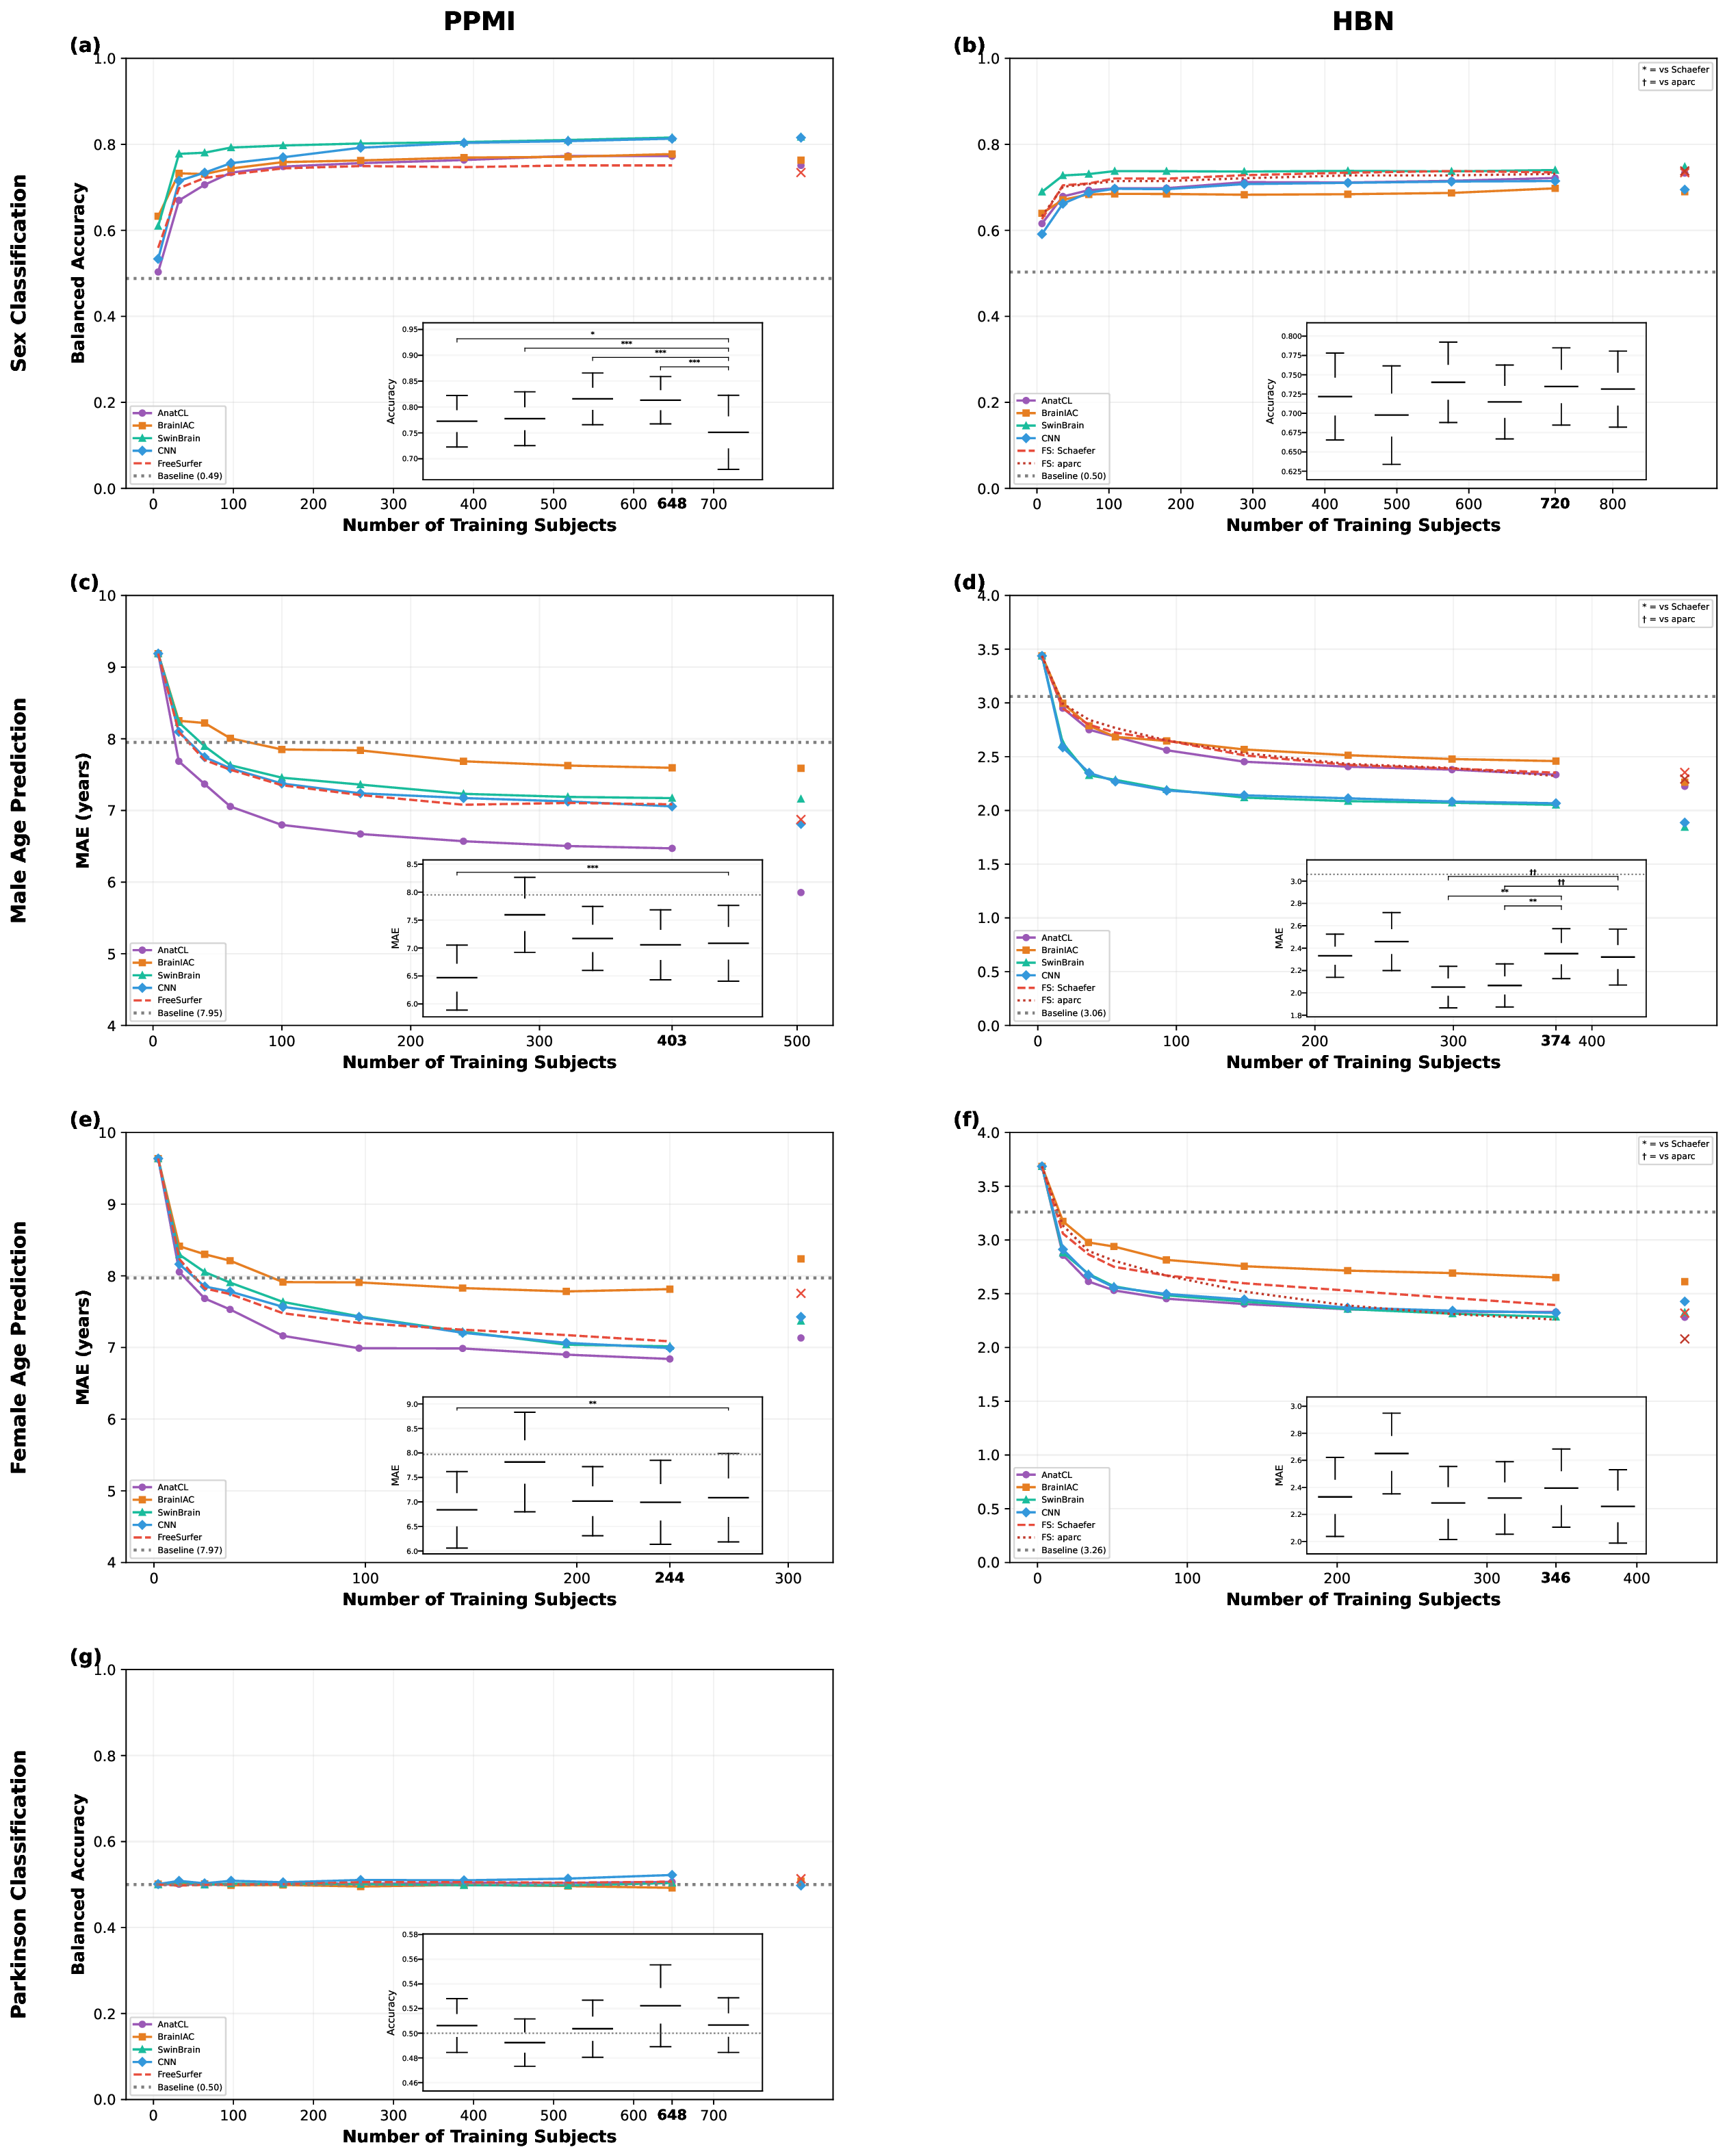

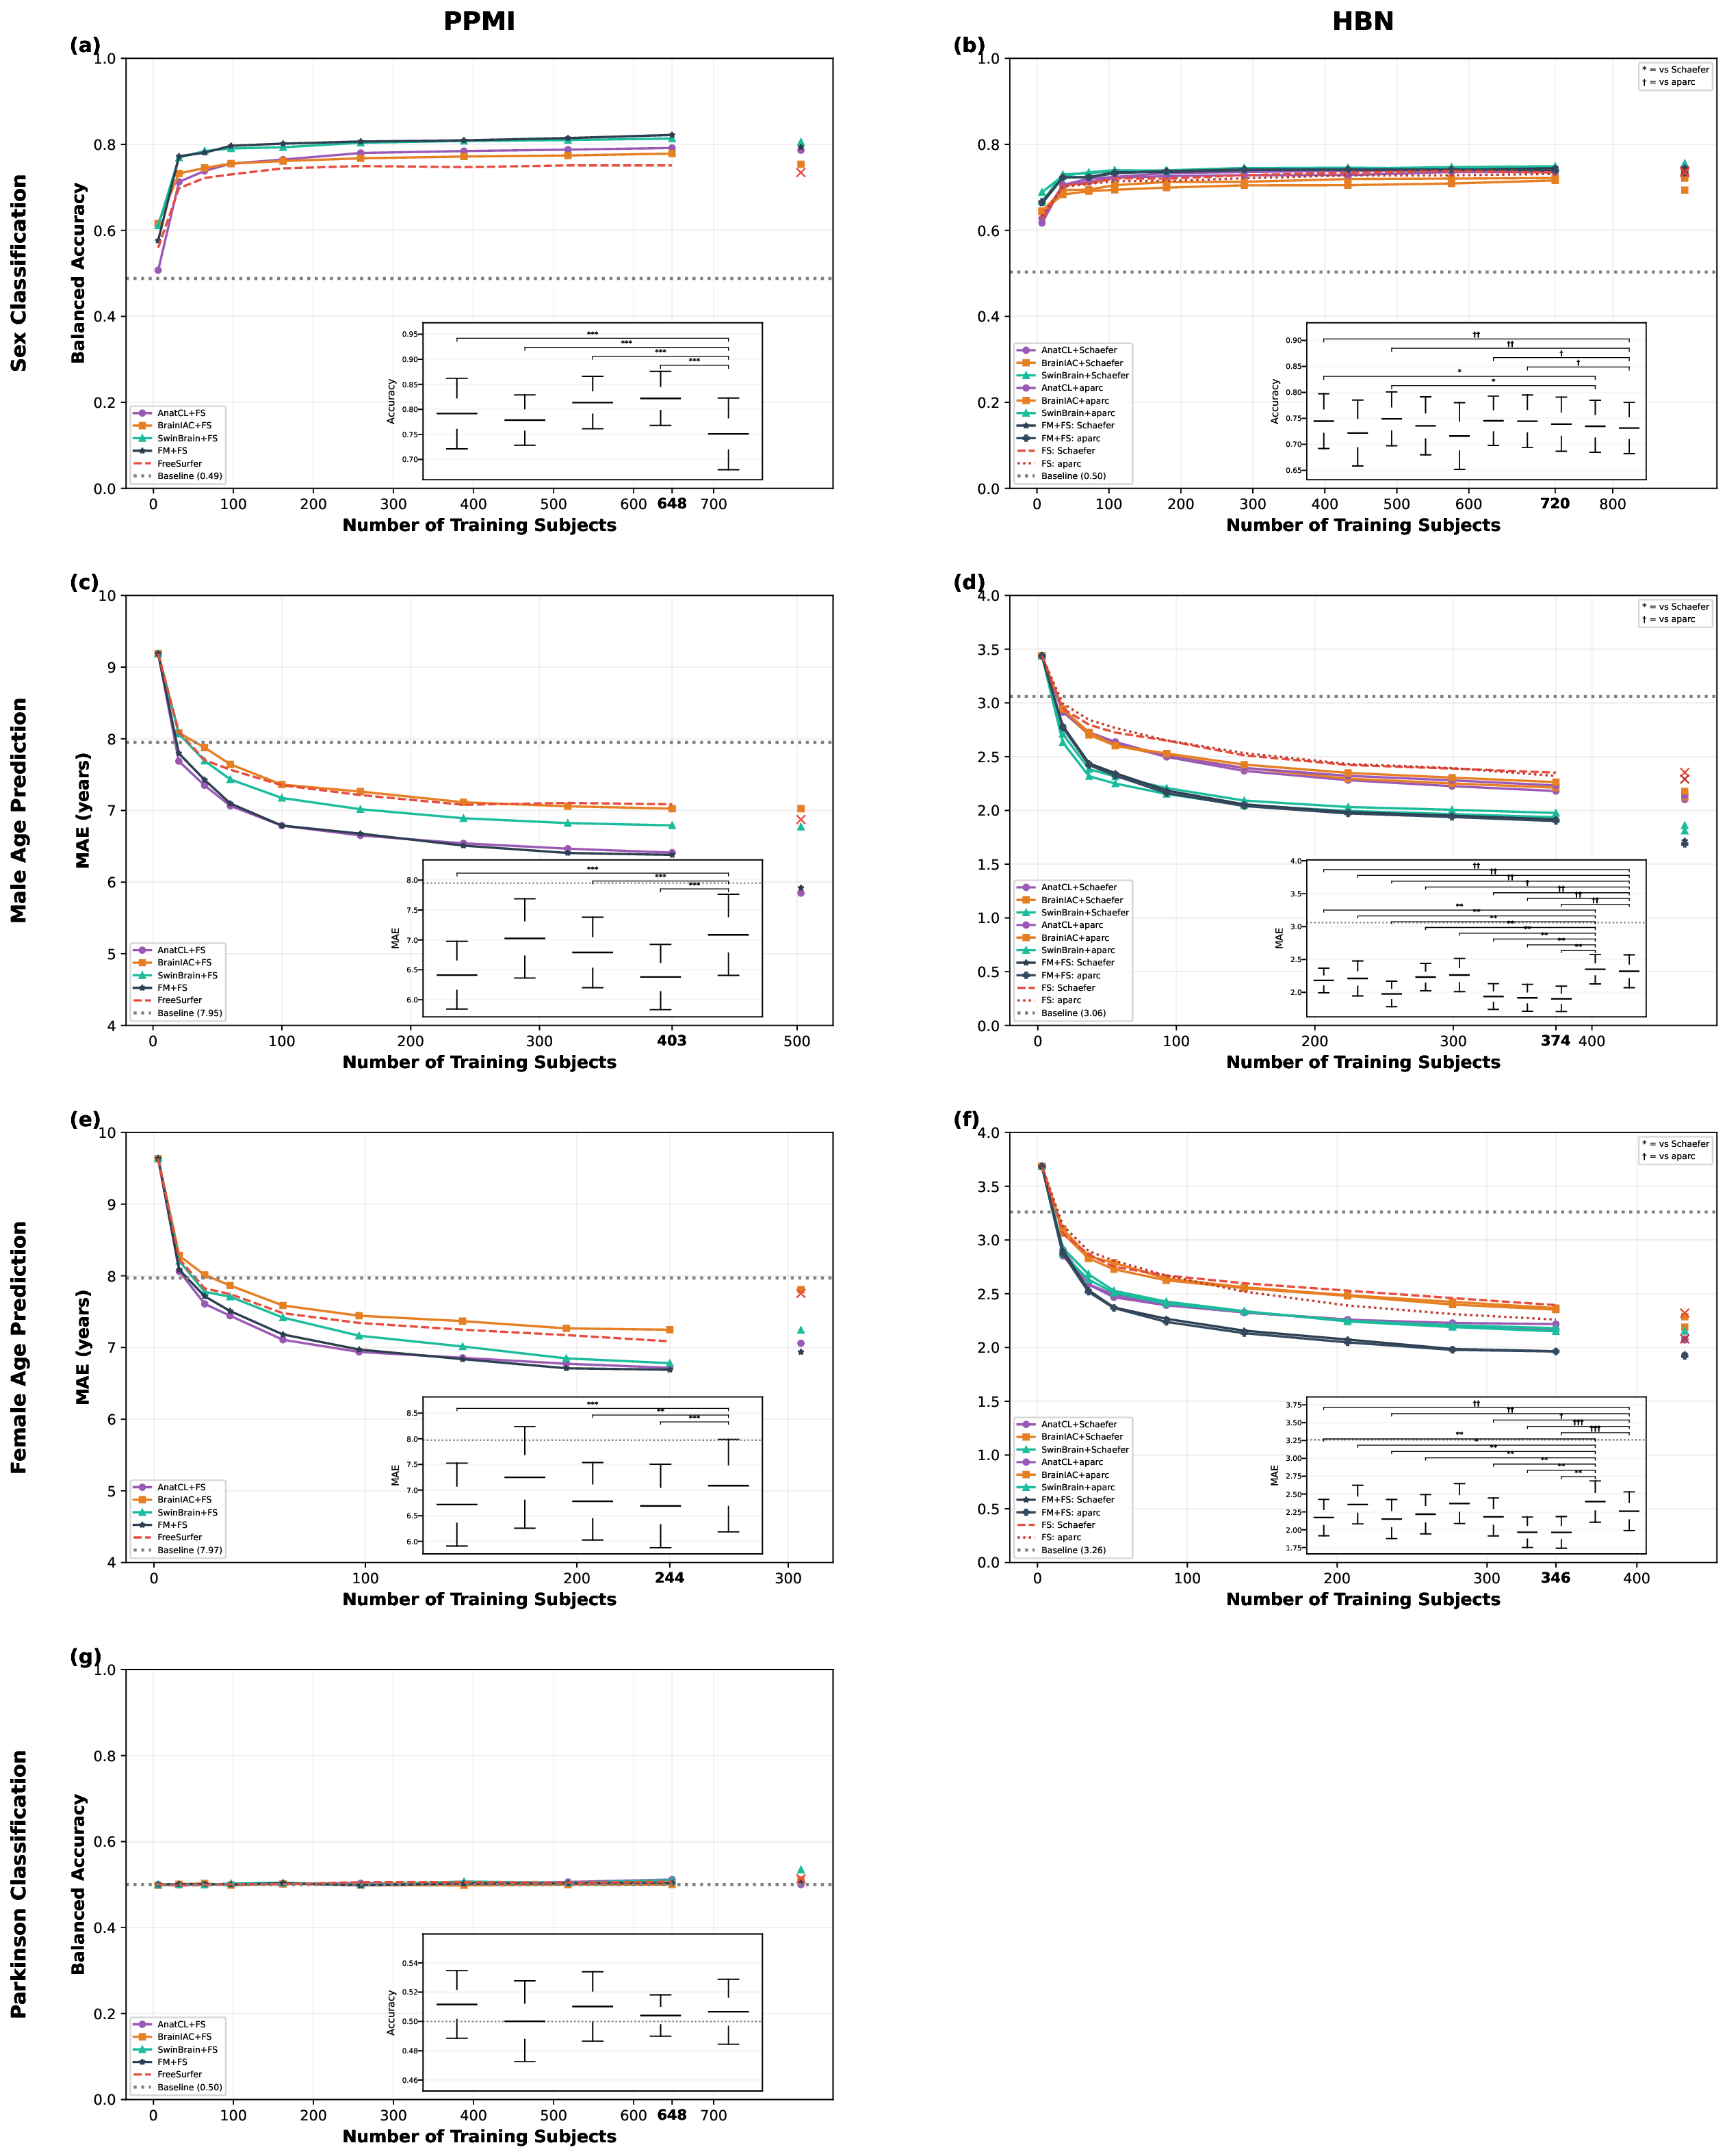


Done!


In [6]:
from IPython.display import display, Image
import subprocess

for pdf in ['learning_curves_main.pdf', 'learning_curves_ablations.pdf']:
    path = f'{OUTPUT_DIR}{pdf}'
    png_path = path.replace('.pdf', '.png')
    subprocess.run(['convert', '-density', '150', path, png_path], check=True)
    display(Image(png_path))

print("\nDone!")